<!-- <img src='./pic/SharifUniLogo.png' alt="SUT logo" width=300 height=300 align=left class="saturate" > <br> -->

<div dir=ltr align=center>
<font color=0F5298 size=7>
    Big Data - Massive Data Mining <br>
<font color=696080 size=5>
    Locality Sensitive Hashing (LSH) <br>
<font color=696880 size=4>
    Mohammad Ali Etemadi Naeen
    
____

## **Install Pypark & Initialization**

In [ ]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("LSH") \
    .master("local[*]") \
    .getOrCreate()

sc=spark.sparkContext

your 131072x1 screen size is bogus. expect trouble
24/12/22 22:23:08 WARN Utils: Your hostname, LAPTOP-1NBL3U8Q resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/12/22 22:23:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/22 22:23:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import os
import re
import json
import string
import random
import squarify
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go

import nltk
from nltk.corpus import stopwords

import hashlib
from hashlib import md5

from wordcloud import WordCloud
from collections import Counter
from itertools import combinations


## **Reading the data**

In [ ]:
arxiv_rdd = sc.textFile("/home/linux/BigData/Dataset/Arxiv-Dataset.json")

In [5]:
arxiv_rdd.take(10)

['{"id":"0704.0001","submitter":"Pavel Nadolsky","authors":"C. Bal\\\\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan","title":"Calculation of prompt diphoton production cross sections at Tevatron and\\n  LHC energies","comments":"37 pages, 15 figures; published version","journal-ref":"Phys.Rev.D76:013009,2007","doi":"10.1103/PhysRevD.76.013009","report-no":"ANL-HEP-PR-07-12","categories":"hep-ph","license":null,"abstract":"  A fully differential calculation in perturbative quantum chromodynamics is\\npresented for the production of massive photon pairs at hadron colliders. All\\nnext-to-leading order perturbative contributions from quark-antiquark,\\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\\nall-orders resummation of initial-state gluon radiation valid at\\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\\nspecified in which the calculation is most reliable. Good agreement is\\ndemonstrated with data from the Fermilab Tevatro

In [5]:
def extract_fields(rdd):
    # Parse the JSON strings & extract all fields
    all_fields = rdd.flatMap(lambda line: json.loads(line).keys()).distinct().collect()
    return all_fields

fields = extract_fields(arxiv_rdd)
print("Unique fields in the dataset:", fields)


Unique fields in the dataset: ['categories', 'title', 'doi', 'versions', 'submitter', 'license', 'authors', 'update_date', 'report-no', 'journal-ref', 'abstract', 'id', 'authors_parsed', 'comments']


In [7]:
print("count:", len(fields))

count: 14


## **Preprocessing**

In this section, we will clean the dataset by removing stop words and irrelevant characters to ensure the data is well-prepared for analysis.


### Part 1: Identify and remove or impute any null values, especially in critical fields

In [4]:
critical_fields = ['title', 'abstract']
# critical_fields = ['title', 'abstract', 'license']

# Convert String to Dict
arxiv_rdd_modify = arxiv_rdd.map(lambda record: json.loads(record))

In [5]:
arxiv_rdd_modify.take(5)


[{'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

##### Remove

In [6]:
# removed_rdd = arxiv_rdd_modify.filter(
#     lambda record: all(record.get(field) is not None for field in critical_fields)
# )

# print("Count after removing nulls:", removed_rdd.count())

In [7]:
# removed_rdd.take(2)

##### Imute

In [8]:
default_values = {
    # 'id': 'unknown_id',
    'title': 'unknown_title',
    'abstract': 'unknown_abstract',
    # 'license': 'unknown_license'
}


In [9]:
imputed_rdd = arxiv_rdd_modify.map(
    lambda record: {
        field: (record.get(field) if record.get(field) is not None else default_values.get(field, 'unknown'))
        for field in record
    }
)

imputed_rdd.take(3)

[{'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': 'unknown',
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated w

### Part 2: find and remove stopwords

In [10]:
# stopwords = {
#     "the", "and", "of", "to", "in", "a", "is", "for", "on", "with", "as", "by",
#     "an", "be", "are", "this", "that", "it", "from", "at", "or", "which", "we",
#     "these", "not", "but", "also", "has", "was", "will", "were", "can", "have",
#     "our", "its", "their"
# }

def remove_stopwords(text, stopwords):

    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stopwords]

    return ' '.join(filtered_words)


In [11]:
nltk.download('stopwords')
stopwords_english = stopwords.words('english')

# Remove stopwords
no_stopwords_rdd = imputed_rdd.map(lambda record: {
    **record,
    'title': remove_stopwords(record.get('title', ''), stopwords_english),
    'abstract': remove_stopwords(record.get('abstract', ''), stopwords_english)
})


[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [12]:
no_stopwords_rdd.take(3)

[{'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation prompt diphoton production cross sections Tevatron LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': 'unknown',
  'abstract': 'fully differential calculation perturbative quantum chromodynamics presented production massive photon pairs hadron colliders. next-to-leading order perturbative contributions quark-antiquark, gluon-(anti)quark, gluon-gluon subprocesses included, well all-orders resummation initial-state gluon radiation valid next-to-next-to-leading logarithmic accuracy. region phase space specified calculation reliable. Good agreement demonstrated data Fermilab Tevatron, predictions made detailed tests CDF data. Predictions shown distributions diphoton p

### Part 3: find and remove useless characters

In [13]:
def clean_dataset_text(text):

    translator = str.maketrans("", "", string.punctuation)
    text = text.translate(translator)

    text = re.sub(r'[^A-Za-z0-9\s]', '', text)

    text = text.lower()

    text = re.sub(r'\s+', ' ', text).strip()

    return text


cleaned_rdd = no_stopwords_rdd.map(lambda record: {
    **record,
    'title': clean_dataset_text(record.get('title', '')),
    'abstract': clean_dataset_text(record.get('abstract', ''))
})

cleaned_rdd.take(3)

[{'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'calculation prompt diphoton production cross sections tevatron lhc energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': 'unknown',
  'abstract': 'fully differential calculation perturbative quantum chromodynamics presented production massive photon pairs hadron colliders nexttoleading order perturbative contributions quarkantiquark gluonantiquark gluongluon subprocesses included well allorders resummation initialstate gluon radiation valid nexttonexttoleading logarithmic accuracy region phase space specified calculation reliable good agreement demonstrated data fermilab tevatron predictions made detailed tests cdf data predictions shown distributions diphoton pairs produced energy 

## **Locality Sensitive Hashing (LSH)**

Total Dataset Size

In [12]:
total_count = cleaned_rdd.count()
print(f"Total number of records in the original dataset: {total_count}")


Total number of records in the original dataset: 2586192


In [17]:
abstract_lengths = cleaned_rdd.map(lambda x: len(x['abstract'])).collect()
average_length = sum(abstract_lengths) / len(abstract_lengths)
print("Average Abstract Length for the Cleaned_RDD:", average_length)

Average Abstract Length for the Cleaned_RDD: 724.2672477526804


Randomly sample 10% of the data

In [53]:
# Randomly sample 10% of the data
subset_fraction = 0.1 
seed = 42  
sampled_rdd = cleaned_rdd.sample(False, subset_fraction, seed)

Count the number of records in the sampled dataset

In [14]:
# Count the number of records in the sampled dataset
sampled_count = sampled_rdd.count()

# Print the result
print(f"Number of records in the sampled dataset: {sampled_count}")


Number of records in the sampled dataset: 258764


---

### First Results - Using 10% of the Dataset

In [25]:
# Randomly sample 10% of the data
subset_fraction = 0.1 
seed = 42  
sampled_rdd = cleaned_rdd.sample(False, subset_fraction, seed)

In [16]:
abstract_lengths = sampled_rdd.map(lambda x: len(x['abstract'])).collect()
average_length = sum(abstract_lengths) / len(abstract_lengths)
print("Average Abstract Length:", average_length)

# Set the K value based on the average length
k = 5 if average_length < 50 else 9

Average Abstract Length: 722.6801641650306


##### K-Shingling (K=9)

In [26]:
def extract_shingles(record, k):
    try:
        # article = json.loads(record)
        # article = record.get()
        abstract = record.get("abstract", "")
        article_id = record.get("id", None)
        
        # Generate k-shingles
        if abstract and article_id:
            shingles = {abstract[i:i+k] for i in range(len(abstract) - k + 1)}
            # Hash each shingle using MD5
            hashed_shingles = {md5(shingle.encode('utf-8')).hexdigest() for shingle in shingles}
            return [(article_id, hashed_shingles)]
            # return [(article_id, shingles)]
        else:
            return []
    except Exception as e:
        return []  

# Extract shingles and hash them
k = 9  
shingled_rdd = sampled_rdd.flatMap(lambda record: extract_shingles(record, k))

In [27]:
debug_rdd = cleaned_rdd.map(lambda record: record.get("abstract", None))
print("Sample abstracts:", debug_rdd.filter(lambda x: x is not None).take(5))


Sample abstracts: ['fully differential calculation perturbative quantum chromodynamics presented production massive photon pairs hadron colliders nexttoleading order perturbative contributions quarkantiquark gluonantiquark gluongluon subprocesses included well allorders resummation initialstate gluon radiation valid nexttonexttoleading logarithmic accuracy region phase space specified calculation reliable good agreement demonstrated data fermilab tevatron predictions made detailed tests cdf data predictions shown distributions diphoton pairs produced energy large hadron collider lhc distributions diphoton pairs decay higgs boson contrasted produced qcd processes lhc showing enhanced sensitivity signal obtained judicious selection events', 'describe new algorithm kellpebble game colors use obtain characterization family kellsparse graphs algorithmic solutions family problems concerning tree decompositions graphs special instances sparse graphs appear rigidity theory received increased a

In [28]:
def extract_raw_shingles(record, k):
    try:
        # article = json.loads(record)
        # article = record.get()
        # abstract = article.get("abstract", "")
        abstract = record.get("abstract", "")
        article_id = record.get("id", None)
        if abstract and article_id:
            shingles = [abstract[i:i+k] for i in range(len(abstract) - k + 1)]
            return [(article_id, shingles)]
        else:
            return []
    except Exception as e:
        print(f"Error: {e}")  
        return []

k = 9
debug_shingles_rdd = cleaned_rdd.flatMap(lambda record: extract_raw_shingles(record, k))
print("Sample shingles:", debug_shingles_rdd.take(3))


Sample shingles: [('0704.0001', ['fully dif', 'ully diff', 'lly diffe', 'ly differ', 'y differe', ' differen', 'different', 'ifferenti', 'fferentia', 'ferential', 'erential ', 'rential c', 'ential ca', 'ntial cal', 'tial calc', 'ial calcu', 'al calcul', 'l calcula', ' calculat', 'calculati', 'alculatio', 'lculation', 'culation ', 'ulation p', 'lation pe', 'ation per', 'tion pert', 'ion pertu', 'on pertur', 'n perturb', ' perturba', 'perturbat', 'erturbati', 'rturbativ', 'turbative', 'urbative ', 'rbative q', 'bative qu', 'ative qua', 'tive quan', 'ive quant', 've quantu', 'e quantum', ' quantum ', 'quantum c', 'uantum ch', 'antum chr', 'ntum chro', 'tum chrom', 'um chromo', 'm chromod', ' chromody', 'chromodyn', 'hromodyna', 'romodynam', 'omodynami', 'modynamic', 'odynamics', 'dynamics ', 'ynamics p', 'namics pr', 'amics pre', 'mics pres', 'ics prese', 'cs presen', 's present', ' presente', 'presented', 'resented ', 'esented p', 'sented pr', 'ented pro', 'nted prod', 'ted produ', 'ed p

In [21]:
shingled_rdd.take(2)

[('0704.0001',
  {'008a1e26c1b56ceab28f2ebb6c8f489f',
   '00c0b9bcdcf6c80bc28f5292404bf1cb',
   '02c45f619b70ebdc51ee3ba26170b4aa',
   '02e4868baea8d5f712702489113e2370',
   '02f515586ace075f722550c19fef3456',
   '032f264ec7b3bfdb8410e4ad1c0ed25a',
   '034b2cc785c1a6fcc4d5bf40facb96a0',
   '03dd0223cd9a1dec1b1f84090b2ef35c',
   '04a7be713129a7390b7b5f6624aa325f',
   '04aab919a951f65fceb0d458cb1c4e38',
   '056ba332fef0f107ff9bc39f3816db56',
   '05966f27cbdf5e1b93a2024ce18bfa06',
   '0691f7c36e4e5ac59c4eb07624e935ed',
   '069bc3c446ae3ed099ccea09e34e9ce2',
   '06e695e58314d04128bb319f6e72a277',
   '07dca29f4270d4c77ece44712f46eab8',
   '088c06305250b2fe72d3a05a63468566',
   '09923c4e08fd481926ef699bc7a35294',
   '09dc3ad4650c69c26cc9b2282ddcd46a',
   '0a0e286f7abac52ea6f9a39e27b46d75',
   '0c31b352404d7da00b21fc062e257267',
   '0c6062646b602ca48f427edf225617fe',
   '0d32355026dee46f64636bf160359f8a',
   '0d6f615053a32c7d014c5f1def985faf',
   '0d95d4be33e3ef139fda9be5c9bcd79c',
   '0dab1e

##### Min-Hash - Signature Matrix

In [29]:
num_hashes = 300  

# Generate Random Hash Functions
max_hash = 2**32 - 1 
hash_functions = [(random.randint(1, max_hash), random.randint(0, max_hash)) for _ in range(num_hashes)]

def minhash_signature(hashed_shingles, hash_functions):
    
    signature = []
    for a, b in hash_functions:
        min_hash = min((a * int(shingle, 16) + b) % max_hash for shingle in hashed_shingles)
        signature.append(min_hash)
    return signature

# Compute Min-Hash Signature for Each Article
signature_rdd = shingled_rdd.mapValues(lambda hashed_shingles: minhash_signature(hashed_shingles, hash_functions))

# Input: shingled_rdd => (article_id, hashed_shingles)
# Output: signature_rdd => (article_id, signature)
print("Sample signatures:", signature_rdd.take(2))


Sample signatures: [('0704.0001', [5777791, 3009069, 4273147, 2726814, 4042945, 2616979, 8882422, 10150504, 8219953, 100397, 18335346, 1833837, 3736504, 602961, 465569, 14962841, 5789263, 2773268, 2591446, 3822916, 1933881, 5208793, 15962334, 18100067, 1549442, 981749, 2748524, 3378171, 2210824, 15288664, 6348613, 1958894, 20280, 3878371, 9036122, 4286225, 2829063, 426294, 1554777, 14700439, 4808460, 447824, 6049839, 5797103, 6590365, 8060268, 4115420, 2495555, 5025592, 1774184, 9837064, 1332926, 4155962, 45771589, 835485, 27897317, 3740523, 8436956, 3175688, 2548124, 5659331, 2327160, 16170861, 13234374, 19536103, 3716632, 32855, 12436394, 507033, 9656035, 1489003, 3432117, 3517685, 3734289, 1859653, 4716804, 3937636, 362872, 3567029, 14675454, 7339661, 1195457, 10733551, 1307972, 36532657, 2047349, 3118855, 574044, 287997, 10741167, 2105777, 811616, 6287022, 11863956, 21978597, 26127968, 105865, 1013432, 10244937, 455838, 6519187, 9586862, 4196333, 6446232, 13371051, 14146640, 265174

In [30]:
signature_rdd.take(2)

[('0704.0001',
  [5777791,
   3009069,
   4273147,
   2726814,
   4042945,
   2616979,
   8882422,
   10150504,
   8219953,
   100397,
   18335346,
   1833837,
   3736504,
   602961,
   465569,
   14962841,
   5789263,
   2773268,
   2591446,
   3822916,
   1933881,
   5208793,
   15962334,
   18100067,
   1549442,
   981749,
   2748524,
   3378171,
   2210824,
   15288664,
   6348613,
   1958894,
   20280,
   3878371,
   9036122,
   4286225,
   2829063,
   426294,
   1554777,
   14700439,
   4808460,
   447824,
   6049839,
   5797103,
   6590365,
   8060268,
   4115420,
   2495555,
   5025592,
   1774184,
   9837064,
   1332926,
   4155962,
   45771589,
   835485,
   27897317,
   3740523,
   8436956,
   3175688,
   2548124,
   5659331,
   2327160,
   16170861,
   13234374,
   19536103,
   3716632,
   32855,
   12436394,
   507033,
   9656035,
   1489003,
   3432117,
   3517685,
   3734289,
   1859653,
   4716804,
   3937636,
   362872,
   3567029,
   14675454,
   7339661,
   1195457,


##### Locality Sensitive Hashing

In [32]:
bands = 20  
rows_per_band = 15  

# bands = 30  
# rows_per_band = 10  

def lsh_buckets(article_id, signature, bands, rows_per_band):

    buckets = []
    for i in range(bands):
        
        start = i * rows_per_band
        end = start + rows_per_band
        band = signature[start:end]
        
        # Hash the band into a bucket
        bucket_id = hash(tuple(band))  
        buckets.append((bucket_id, article_id))
    return buckets

# Apply LSH to generate buckets
buckets_rdd = signature_rdd.flatMap(lambda x: lsh_buckets(x[0], x[1], bands, rows_per_band))
# Input: signature_rdd => (article_id, signature)
# Output: buckets_rdd => (bucket_id, article_id)

# Group articles in the same bucket
grouped_buckets = buckets_rdd.groupByKey().mapValues(list)
# Output: grouped_buckets => (bucket_id, [article_id1, article_id2, ...])

print("Sample buckets with articles:", grouped_buckets.take(2))

# Extract Candidate Pairs
def generate_pairs(bucket):

    _, articles = bucket
    return [(articles[i], articles[j]) for i in range(len(articles)) for j in range(i + 1, len(articles))]

# Generate candidate pairs
# candidate_pairs = grouped_buckets.flatMap(generate_pairs)
candidate_pairs = grouped_buckets.flatMap(generate_pairs).map(lambda pair: tuple(sorted(pair))).distinct()
candidate_pairs = candidate_pairs.distinct()

print("Sample candidate pairs:", candidate_pairs.take(5))


Sample buckets with articles: [(-1294748948629152542, ['0704.0118']), (2447392767811541547, ['0704.0123'])]


Sample candidate pairs: [('quant-ph/0111027', 'quant-ph/0511164'), ('1112.3544', 'physics/0507203'), ('astro-ph/0303035', 'cond-mat/9907253'), ('cond-mat/0105142', 'cond-mat/9904049'), ('cond-mat/0410032', 'quant-ph/0211147')]


In [33]:
grouped_buckets.take(10)

[(-1294748948629152542, ['0704.0118']),
 (2447392767811541547, ['0704.0123']),
 (5529329997860335614, ['0704.0175']),
 (-9109027243390841648, ['0704.0279']),
 (5374183072894218789, ['0704.0367']),
 (-5073699695413069724, ['0704.0398']),
 (6110672358100593189, ['0704.0509']),
 (1000508066641343024, ['0704.0648']),
 (-4915159364371841802, ['0704.0729']),
 (-6022526960120517406, ['0704.0818'])]

In [34]:
candidate_pairs.take(10)

[('quant-ph/0111027', 'quant-ph/0511164'),
 ('1112.3544', 'physics/0507203'),
 ('astro-ph/0303035', 'cond-mat/9907253'),
 ('cond-mat/0105142', 'cond-mat/9904049'),
 ('cond-mat/0410032', 'quant-ph/0211147'),
 ('cond-mat/0204158', 'cond-mat/9807269'),
 ('cond-mat/0204158', 'math/0310320'),
 ('physics/0512129', 'quant-ph/0611120'),
 ('0712.2753', 'cs/0612028'),
 ('1210.4544', 'cs/0612028')]

In [35]:
print(candidate_pairs.filter(lambda x: "quant-ph/0111027" in x).collect())


[('quant-ph/0111027', 'quant-ph/0511164'), ('nlin/0304041', 'quant-ph/0111027'), ('hep-ph/9607327', 'quant-ph/0111027'), ('math/0310320', 'quant-ph/0111027'), ('hep-th/0607026', 'quant-ph/0111027'), ('cond-mat/9807269', 'quant-ph/0111027'), ('hep-ph/9702437', 'quant-ph/0111027'), ('cond-mat/0611766', 'quant-ph/0111027'), ('astro-ph/0302340', 'quant-ph/0111027'), ('0709.4303', 'quant-ph/0111027'), ('physics/0512129', 'quant-ph/0111027'), ('cond-mat/0204158', 'quant-ph/0111027'), ('math/0512426', 'quant-ph/0111027'), ('quant-ph/0111027', 'quant-ph/0611120'), ('0902.3550', 'quant-ph/0111027'), ('1002.0246', 'quant-ph/0111027'), ('cond-mat/9709042', 'quant-ph/0111027')]


In [33]:
keyed_shingled_rdd = shingled_rdd.map(lambda x: (x[0], x[1]))  

def compute_similarity(pair_shingles):
    
    ((id1, id2), (shingles1, shingles2)) = pair_shingles

    shingles1 = set(shingles1)
    shingles2 = set(shingles2)

    intersection = len(shingles1 & shingles2)
    union = len(shingles1 | shingles2)
    similarity = intersection / union if union != 0 else 0.0
    
    return (id1, id2, similarity)


def filter_candidates(candidate, input_id):
    return candidate[0] == input_id or candidate[1] == input_id


def find_similar_articles(input_article_id, threshold=0.8):

    filtered_candidates = candidate_pairs.filter(
        lambda pair: filter_candidates(pair, input_article_id)
    )

    joined_candidates = (
        filtered_candidates
        .map(lambda pair: (pair[0], pair))  
        .join(keyed_shingled_rdd)  
        .map(lambda x: (x[1][0][1], (x[1][0][0], x[1][1]))) 
        .join(keyed_shingled_rdd)  
        .map(lambda x: ((x[1][0][0], x[0]), (set(x[1][0][1]), set(x[1][1]))))  
    )

    similar_articles = (
        joined_candidates
        .map(lambda pair: compute_similarity(pair))  
        .filter(lambda x: x[2] >= threshold)  
    )

    return similar_articles.collect()

input_article_id = "0709.4303" 
threshold = 0.8  
similar_articles = find_similar_articles(input_article_id, threshold=threshold)

print(f"Articles similar to {input_article_id}:", similar_articles)


Articles similar to 0709.4303: [('0709.4303', 'cond-mat/9807269', 1.0), ('0709.4303', 'cond-mat/9807269', 1.0), ('0709.4303', 'cond-mat/9807269', 1.0), ('0709.4303', 'cond-mat/9807269', 1.0), ('0709.4303', 'cond-mat/9807269', 1.0), ('0709.4303', 'cond-mat/9807269', 1.0), ('0709.4303', 'cond-mat/9807269', 1.0), ('0709.4303', 'cond-mat/9807269', 1.0), ('0709.4303', 'cond-mat/9807269', 1.0), ('0709.4303', 'cond-mat/9807269', 1.0), ('0709.4303', 'cond-mat/9807269', 1.0), ('0709.4303', 'cond-mat/9807269', 1.0), ('0709.4303', 'cond-mat/9807269', 1.0), ('0709.4303', 'cond-mat/9807269', 1.0), ('0709.4303', 'cond-mat/9807269', 1.0), ('0709.4303', 'cond-mat/9807269', 1.0), ('0709.4303', 'cond-mat/9807269', 1.0), ('0709.4303', 'cond-mat/9807269', 1.0), ('0709.4303', 'cond-mat/9807269', 1.0), ('0709.4303', 'cond-mat/9807269', 1.0), ('0709.4303', 'hep-th/0607026', 1.0), ('0709.4303', 'hep-th/0607026', 1.0), ('0709.4303', 'hep-th/0607026', 1.0), ('0709.4303', 'hep-th/0607026', 1.0), ('0709.4303', 'h

In [37]:
keyed_shingled_rdd = shingled_rdd.map(lambda x: (x[0], x[1]))  


def compute_similarity(pair_shingles):

    ((id1, id2), (shingles1, shingles2)) = pair_shingles

    shingles1 = set(shingles1)
    shingles2 = set(shingles2)

    intersection = len(shingles1 & shingles2)
    union = len(shingles1 | shingles2)
    similarity = intersection / union if union != 0 else 0.0
    return (id1, id2, similarity)

def filter_candidates(candidate, input_id):
    return candidate[0] == input_id or candidate[1] == input_id

def find_similar_articles(input_article_id, threshold=0.8):

    filtered_candidates = candidate_pairs.filter(
        lambda pair: filter_candidates(pair, input_article_id)
    )

    joined_candidates = (
        filtered_candidates
        .map(lambda pair: (pair[0], pair)) 
        .join(keyed_shingled_rdd) 
        .map(lambda x: (x[1][0][1], (x[1][0][0], x[1][1]))) 
        .join(keyed_shingled_rdd)  
        .map(lambda x: ((x[1][0][0], x[0]), (set(x[1][0][1]), set(x[1][1])))) 
    )

    similar_articles = (
        joined_candidates
        .map(lambda pair: compute_similarity(pair)) 
        .filter(lambda x: x[2] >= threshold) 
    )

    return similar_articles.collect()

input_article_id = "quant-ph/0111027"  
threshold = 0.8  
similar_articles = find_similar_articles(input_article_id, threshold=threshold)

print(f"Articles similar to {input_article_id}:", similar_articles)


Articles similar to quant-ph/0111027: [('quant-ph/0111027', 'quant-ph/0611120', 1.0), ('cond-mat/9807269', 'quant-ph/0111027', 1.0), ('1002.0246', 'quant-ph/0111027', 1.0), ('hep-th/0607026', 'quant-ph/0111027', 1.0), ('0902.3550', 'quant-ph/0111027', 1.0), ('math/0512426', 'quant-ph/0111027', 1.0), ('hep-ph/9607327', 'quant-ph/0111027', 1.0), ('0709.4303', 'quant-ph/0111027', 1.0), ('hep-ph/9702437', 'quant-ph/0111027', 1.0), ('physics/0512129', 'quant-ph/0111027', 1.0), ('cond-mat/0204158', 'quant-ph/0111027', 1.0), ('nlin/0304041', 'quant-ph/0111027', 1.0), ('math/0310320', 'quant-ph/0111027', 1.0), ('astro-ph/0302340', 'quant-ph/0111027', 1.0), ('cond-mat/0611766', 'quant-ph/0111027', 1.0), ('cond-mat/9709042', 'quant-ph/0111027', 1.0), ('quant-ph/0111027', 'quant-ph/0511164', 1.0)]


##### Test 1st Article

In [27]:
keyed_shingled_rdd = shingled_rdd.map(lambda x: (x[0], x[1]))  

def compute_similarity(pair_shingles):
    
    ((id1, id2), (shingles1, shingles2)) = pair_shingles

    shingles1 = set(shingles1)
    shingles2 = set(shingles2)

    intersection = len(shingles1 & shingles2)
    union = len(shingles1 | shingles2)
    similarity = intersection / union if union != 0 else 0.0
    
    return (id1, id2, similarity)


def filter_candidates(candidate, input_id):
    return candidate[0] == input_id or candidate[1] == input_id


def find_similar_articles(input_article_id, threshold=0.8):

    filtered_candidates = candidate_pairs.filter(
        lambda pair: filter_candidates(pair, input_article_id)
    )

    joined_candidates = (
        filtered_candidates
        .map(lambda pair: (pair[0], pair))  
        .join(keyed_shingled_rdd)  
        .map(lambda x: (x[1][0][1], (x[1][0][0], x[1][1]))) 
        .join(keyed_shingled_rdd)  
        .map(lambda x: ((x[1][0][0], x[0]), (set(x[1][0][1]), set(x[1][1]))))  
    )

    similar_articles = (
        joined_candidates
        .map(lambda pair: compute_similarity(pair))  
        .filter(lambda x: x[2] >= threshold)  
    )

    return similar_articles.collect()

input_article_id = "hep-ph/9607327"  
threshold = 0.8  
similar_articles = find_similar_articles(input_article_id, threshold=threshold)

print(f"Articles similar to {input_article_id}:", similar_articles)


Articles similar to hep-ph/9607327: [('hep-ph/9607327', 'math/0310320', 1.0), ('hep-ph/9607327', 'math/0512426', 1.0), ('hep-ph/9607327', 'quant-ph/0611120', 1.0), ('0902.3550', 'hep-ph/9607327', 1.0), ('1002.0246', 'hep-ph/9607327', 1.0), ('cond-mat/9807269', 'hep-ph/9607327', 1.0), ('0709.4303', 'hep-ph/9607327', 1.0), ('cond-mat/9709042', 'hep-ph/9607327', 1.0), ('cond-mat/0204158', 'hep-ph/9607327', 1.0), ('astro-ph/0302340', 'hep-ph/9607327', 1.0), ('cond-mat/0611766', 'hep-ph/9607327', 1.0), ('hep-ph/9607327', 'physics/0512129', 1.0), ('hep-ph/9607327', 'quant-ph/0511164', 1.0), ('hep-ph/9607327', 'hep-th/0607026', 1.0), ('hep-ph/9607327', 'nlin/0304041', 1.0), ('hep-ph/9607327', 'hep-ph/9702437', 1.0), ('hep-ph/9607327', 'quant-ph/0111027', 1.0)]


In [23]:
print(keyed_shingled_rdd.filter(lambda x: x[0] == "quant-ph/0111027").collect())
print(keyed_shingled_rdd.filter(lambda x: x[0] in ["quant-ph/0611120", "cond-mat/9807269"]).collect())


[('quant-ph/0111027', {'c06583307d1e8659e83f55f2ba73a043', 'd9038560782fe90f3479e2b3de832235', 'ade5db562db52f45dce869b0554e8225', '53401622d77b9de84fb3f795fff5065c', 'db17b016ba0bb1a2746a44c9c30d84c1', '8bc713d25d040c3faac36ac16898d329', '5938237efdaab5129af5ec434914cc8a'})]


[('cond-mat/9807269', {'c06583307d1e8659e83f55f2ba73a043', 'd9038560782fe90f3479e2b3de832235', 'ade5db562db52f45dce869b0554e8225', '53401622d77b9de84fb3f795fff5065c', 'db17b016ba0bb1a2746a44c9c30d84c1', '8bc713d25d040c3faac36ac16898d329', '5938237efdaab5129af5ec434914cc8a'}), ('quant-ph/0611120', {'c06583307d1e8659e83f55f2ba73a043', 'd9038560782fe90f3479e2b3de832235', 'ade5db562db52f45dce869b0554e8225', '53401622d77b9de84fb3f795fff5065c', 'db17b016ba0bb1a2746a44c9c30d84c1', '8bc713d25d040c3faac36ac16898d329', '5938237efdaab5129af5ec434914cc8a'})]


In [39]:
print(sampled_rdd.filter(lambda x: x['id'] == "quant-ph/0111027").collect())
print(sampled_rdd.filter(lambda x: x['id'] in ["quant-ph/0611120", "cond-mat/9807269"]).collect())

[{'id': 'quant-ph/0111027', 'submitter': 'Peter Morgan', 'authors': 'Peter Morgan', 'title': 'classical nonlocal models quantum field states', 'comments': 'This paper is withdrawn', 'journal-ref': 'unknown', 'doi': 'unknown', 'report-no': 'POPP-005', 'categories': 'quant-ph cond-mat math-ph math.MP', 'license': 'unknown', 'abstract': 'paper withdrawn', 'versions': [{'version': 'v1', 'created': 'Mon, 5 Nov 2001 14:54:57 GMT'}, {'version': 'v2', 'created': 'Mon, 17 Dec 2001 14:40:20 GMT'}, {'version': 'v3', 'created': 'Sun, 24 Mar 2002 11:01:52 GMT'}, {'version': 'v4', 'created': 'Fri, 6 Sep 2002 19:19:18 GMT'}, {'version': 'v5', 'created': 'Thu, 2 Jan 2003 14:36:46 GMT'}], 'update_date': '2007-05-23', 'authors_parsed': [['Morgan', 'Peter', '']]}]


[{'id': 'cond-mat/9807269', 'submitter': 'Kenichiro Imura', 'authors': 'Ken-ichiro Imura', 'title': 'persistent edge current fractional quantum hall liquids', 'comments': 'Withdrawn', 'journal-ref': 'unknown', 'doi': 'unknown', 'report-no': 'unknown', 'categories': 'cond-mat', 'license': 'unknown', 'abstract': 'paper withdrawn', 'versions': [{'version': 'v1', 'created': 'Sun, 19 Jul 1998 19:18:31 GMT'}, {'version': 'v2', 'created': 'Fri, 24 Jul 1998 10:04:19 GMT'}, {'version': 'v3', 'created': 'Thu, 20 Aug 1998 12:08:36 GMT'}], 'update_date': '2007-05-23', 'authors_parsed': [['Imura', 'Ken-ichiro', '']]}, {'id': 'quant-ph/0611120', 'submitter': 'Bing Qi', 'authors': 'Lei-Lei Huang, Bing Qi, Li Qian, Hoi-Kwong Lo', 'title': 'continuousvariables quantum key distribution standard telecom fiber', 'comments': 'This paper has been withdrawn', 'journal-ref': 'unknown', 'doi': 'unknown', 'report-no': 'unknown', 'categories': 'quant-ph', 'license': 'unknown', 'abstract': 'paper withdrawn', 'ver

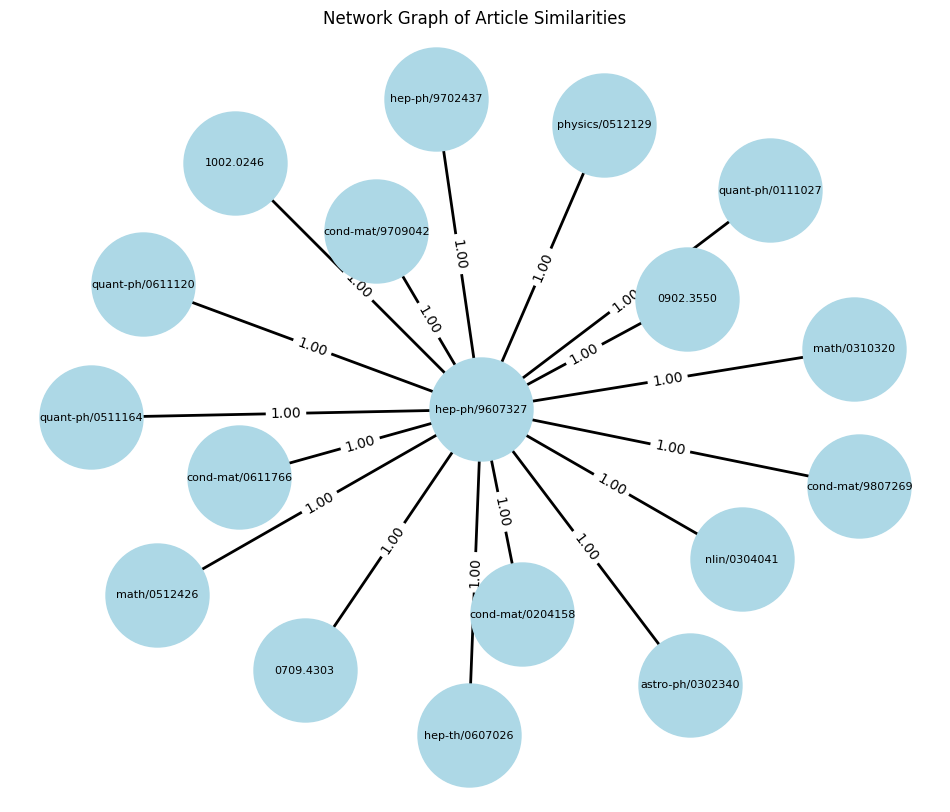

In [49]:
G = nx.Graph()

for article1, article2, similarity in similar_articles:
    G.add_edge(article1, article2, weight=similarity)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)  
weights = nx.get_edge_attributes(G, 'weight')

nx.draw_networkx_nodes(G, pos, node_size=5500, node_color="lightblue")
nx.draw_networkx_edges(G, pos, width=[v * 2 for v in weights.values()])
nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in weights.items()})

plt.title("Network Graph of Article Similarities")
plt.axis("off")
plt.show()


##### Test 2nd Article

In [59]:
check = '0903.1797'

is_available = candidate_pairs.filter(lambda pair: check in pair).isEmpty() == False

print(f"'{check}' is {'available' if is_available else 'not available'}")


'0903.1797' is available


In [60]:
article_details = sampled_rdd \
    .filter(lambda record: record.get("id") == "0903.1797") \
    .collect()

if article_details:
    for article in article_details:
        print(json.dumps(article, indent=4))
else:
    print("No article found with id = 2109.03245")


{
    "id": "0903.1797",
    "submitter": "Michael Thoennessen",
    "authors": "A. Schuh, A. Fritsch, J.Q. Ginepro, M. Heim, A. Shore, and\n  M.Thoennessen",
    "title": "discovery gold isotopes",
    "comments": "to be published in At. Data. Nucl. Data Tables",
    "journal-ref": "Atom.Data Nucl.Data Tabl.96:307,2010",
    "doi": "10.1016/j.adt.2009.12.001",
    "report-no": "unknown",
    "categories": "nucl-ex",
    "license": "http://arxiv.org/licenses/nonexclusive-distrib/1.0/",
    "abstract": "thirtysix gold isotopes far observed discovery isotopes discussed isotope brief summary first refereed publication including production identification method presented",
    "versions": [
        {
            "version": "v1",
            "created": "Tue, 10 Mar 2009 15:43:26 GMT"
        }
    ],
    "update_date": "2014-11-18",
    "authors_parsed": [
        [
            "Schuh",
            "A.",
            ""
        ],
        [
            "Fritsch",
            "A.",
          

In [61]:
keyed_shingled_rdd = shingled_rdd.map(lambda x: (x[0], x[1]))  

def compute_similarity(pair_shingles):

    ((id1, id2), (shingles1, shingles2)) = pair_shingles
   
    shingles1 = set(shingles1)
    shingles2 = set(shingles2)
  
    intersection = len(shingles1 & shingles2)
    union = len(shingles1 | shingles2)
    similarity = intersection / union if union != 0 else 0.0
    return (id1, id2, similarity)

def filter_candidates(candidate, input_id):
    return candidate[0] == input_id or candidate[1] == input_id

def find_similar_articles(input_article_id, threshold=0.8):

    filtered_candidates = candidate_pairs.filter(
        lambda pair: filter_candidates(pair, input_article_id)
    )

    joined_candidates = (
        filtered_candidates
        .map(lambda pair: (pair[0], pair))  
        .join(keyed_shingled_rdd)  
        .map(lambda x: (x[1][0][1], (x[1][0][0], x[1][1]))) 
        .join(keyed_shingled_rdd)  
        .map(lambda x: ((x[1][0][0], x[0]), (set(x[1][0][1]), set(x[1][1])))) 
    )

    similar_articles = (
        joined_candidates
        .map(lambda pair: compute_similarity(pair))  
        .filter(lambda x: x[2] >= threshold)  
    )

    return similar_articles.collect()

input_article_id = "0903.1797"  
threshold = 0.5  
similar_articles = find_similar_articles(input_article_id, threshold=threshold)

print(f"Articles similar to {input_article_id}:", similar_articles)


Articles similar to 0903.1797: [('0903.1797', '0907.1994', 0.8171428571428572), ('0903.1797', '1004.4934', 0.8171428571428572), ('0903.1797', '0910.4231', 0.8171428571428572), ('0903.1797', '0903.4281', 0.8171428571428572)]


##### Test 3rd Article

In [75]:
check = '1004.4934'

is_available = candidate_pairs.filter(lambda pair: check in pair).isEmpty() == False

print(f"'{check}' is {'available' if is_available else 'not available'}")


'1004.4934' is available


In [71]:
article_details = sampled_rdd \
    .filter(lambda record: record.get("id") == "1004.4934") \
    .collect()

if article_details:
    for article in article_details:
        print(json.dumps(article, indent=4))
else:
    print("No article found with id = 1004.4934")


{
    "id": "1004.4934",
    "submitter": "Michael Thoennessen",
    "authors": "J.L. Gross and M. Thoennessen",
    "title": "discovery calcium isotopes",
    "comments": "This paper has been withdrawn by the authors. This manuscript has\n  been combined with the manuscripts on Indium, Tin and Platinum and can be\n  found at arXiv:1006.4033v1 to be published in Atomic Data Nuclear Data",
    "journal-ref": "unknown",
    "doi": "unknown",
    "report-no": "unknown",
    "categories": "nucl-ex",
    "license": "http://arxiv.org/licenses/nonexclusive-distrib/1.0/",
    "abstract": "twenty four calcium isotopes far observed discovery isotopes discussed isotope brief summary first refereed publication including production identification method presented",
    "versions": [
        {
            "version": "v1",
            "created": "Wed, 28 Apr 2010 00:35:28 GMT"
        },
        {
            "version": "v2",
            "created": "Wed, 8 Sep 2010 17:11:56 GMT"
        }
    ],
    

In [78]:
article_details[0]['abstract']

'twenty four calcium isotopes far observed discovery isotopes discussed isotope brief summary first refereed publication including production identification method presented'

In [72]:
input_article_id = "1004.4934" 
threshold = 0.5 
similar_articles = find_similar_articles(input_article_id, threshold=threshold)

print(f"Articles similar to {input_article_id}:", similar_articles)


Articles similar to 1004.4934: [('0907.1994', '1004.4934', 0.8202247191011236), ('0910.4231', '1004.4934', 0.8202247191011236), ('0903.1797', '1004.4934', 0.8171428571428572), ('0903.4281', '1004.4934', 0.7900552486187845)]


In [76]:
print(keyed_shingled_rdd.filter(lambda x: x[0] == "1004.4934").collect())
print(keyed_shingled_rdd.filter(lambda x: x[0] == "0907.1994").collect())
print(keyed_shingled_rdd.filter(lambda x: x[0] == "0903.4281").collect())



[('1004.4934', {'82681515fe10bc4d25af55117271bce2', '617cf44206ca2219f20ff4285a0786b3', 'd635317568beb704a0e50bff00cdc904', '4f7d7fe862a167f75fd73067483c9fa9', 'd8b572cbc8842e8d0f0ee42fced2323b', '08fdb58580290247e399e1970647dee7', '88350c1ed470d759b895529f5f23732a', 'e1bf2f88138934a7495880f9b66d7441', '86c4853a7fe844af913c8cba9c10cebe', 'f541f2f425e4aa4c6e89cb367b961ea8', '450ff8f5738bbe605b8411d3204b6be1', '956a4cd42bef6f4db054b8409addd146', 'a05d8286193a328dec241dcdcafe35c6', '33d25f1ed16e6e3ff0047fde4449dcf4', '5630303739736e93cc51bc8a1e6643de', '3f8b48c79be58663078d3863853ef4b4', '8aeb132e6818ccf9db44e6084329a7ce', 'd0aa2eb1439c80cad3a1098cc02d3836', '5abc358a9905db10e888e60408e78003', '26a8d93c7f79300aebc06f92643c0958', 'd790a1a4997e23c9ba025b3ee421618e', 'c2cff486d5b12527f4a99ef1ae8d3dac', 'b96a1391ee0688551b4d852a30e3415a', 'd0c53cd0268ad95ddf661ad1e1851efc', 'e9eb3c238bbf7dcbacce551078f2c67a', 'cc38d6dce407eb51f22f29467db03c2d', '636a9bb58a27527be3b4ffa38e310929', '8134a45bbd1

[('0907.1994', {'3ba341804e59bab61a41e65a3fe5a04b', 'c0676c202b285ef12bdff1f8f5efec74', '82681515fe10bc4d25af55117271bce2', '617cf44206ca2219f20ff4285a0786b3', 'd635317568beb704a0e50bff00cdc904', '4f7d7fe862a167f75fd73067483c9fa9', 'd8b572cbc8842e8d0f0ee42fced2323b', '88350c1ed470d759b895529f5f23732a', 'e1bf2f88138934a7495880f9b66d7441', '86c4853a7fe844af913c8cba9c10cebe', '956a4cd42bef6f4db054b8409addd146', 'a05d8286193a328dec241dcdcafe35c6', '33d25f1ed16e6e3ff0047fde4449dcf4', 'c01557ca16e247e9719b62f9d2bf1402', '07f9f48fee86fc59fd4100fa6eaa333a', 'c26a3de90c11351014a60ea5ee62aa57', '3f8b48c79be58663078d3863853ef4b4', '8aeb132e6818ccf9db44e6084329a7ce', 'd0aa2eb1439c80cad3a1098cc02d3836', '5abc358a9905db10e888e60408e78003', '26a8d93c7f79300aebc06f92643c0958', 'd790a1a4997e23c9ba025b3ee421618e', 'c2cff486d5b12527f4a99ef1ae8d3dac', 'b96a1391ee0688551b4d852a30e3415a', 'd0c53cd0268ad95ddf661ad1e1851efc', 'e9eb3c238bbf7dcbacce551078f2c67a', 'cc38d6dce407eb51f22f29467db03c2d', '636a9bb58a2

[('0903.4281', {'82681515fe10bc4d25af55117271bce2', '617cf44206ca2219f20ff4285a0786b3', 'd635317568beb704a0e50bff00cdc904', '03be341eb37c39b39603473274c192fe', '4f7d7fe862a167f75fd73067483c9fa9', 'd8b572cbc8842e8d0f0ee42fced2323b', '1b5b6c285d5c25bbc53d19d938af1113', '88350c1ed470d759b895529f5f23732a', 'e1bf2f88138934a7495880f9b66d7441', '86c4853a7fe844af913c8cba9c10cebe', '961db7518deb90f37ff8dd2afffa1497', '956a4cd42bef6f4db054b8409addd146', 'a05d8286193a328dec241dcdcafe35c6', '33d25f1ed16e6e3ff0047fde4449dcf4', '3f8b48c79be58663078d3863853ef4b4', '8aeb132e6818ccf9db44e6084329a7ce', '77fe3f1b0027f45eb3c01ec2062f2576', 'd0aa2eb1439c80cad3a1098cc02d3836', '5abc358a9905db10e888e60408e78003', '26a8d93c7f79300aebc06f92643c0958', 'd790a1a4997e23c9ba025b3ee421618e', 'c2cff486d5b12527f4a99ef1ae8d3dac', 'b96a1391ee0688551b4d852a30e3415a', 'd0c53cd0268ad95ddf661ad1e1851efc', '29e99fb4659daf1c2c6e1a8db7f519f6', 'e9eb3c238bbf7dcbacce551078f2c67a', 'cc38d6dce407eb51f22f29467db03c2d', '636a9bb58a2

In [ ]:
print(sampled_rdd.filter(lambda x: x['id'] == "1004.4934").collect()[0]['abstract'])
print("-------------------------------------------------------")
print(sampled_rdd.filter(lambda x: x['id'] == "0907.1994").collect()[0]['abstract'])
print("-------------------------------------------------------")
print(sampled_rdd.filter(lambda x: x['id'] == "0903.4281").collect()[0]['abstract'])


twenty four calcium isotopes far observed discovery isotopes discussed isotope brief summary first refereed publication including production identification method presented
-------------------------------------------------------


twentyfour vanadium isotopes far observed discovery isotopes discussed isotope brief summary first refereed publication including production identification method presented
-------------------------------------------------------


thirtyfive tungsten isotopes far observed discovery isotopes discussed isotope brief summary first refereed publication including production identification method presented


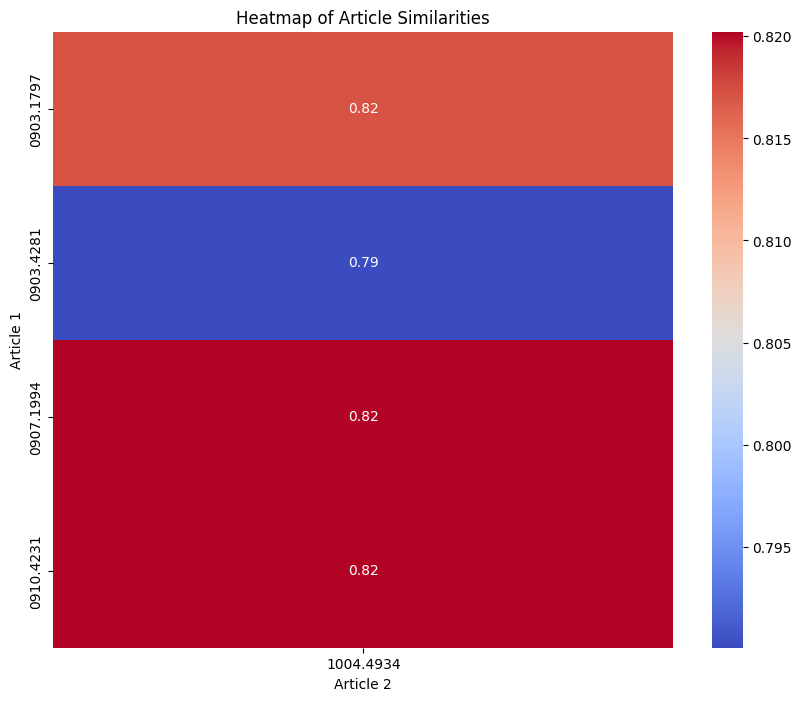

In [73]:
df_similar = pd.DataFrame(similar_articles, columns=["Article 1", "Article 2", "Similarity"])

heatmap_data = df_similar.pivot(index="Article 1", columns="Article 2", values="Similarity")

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap of Article Similarities")
plt.show()


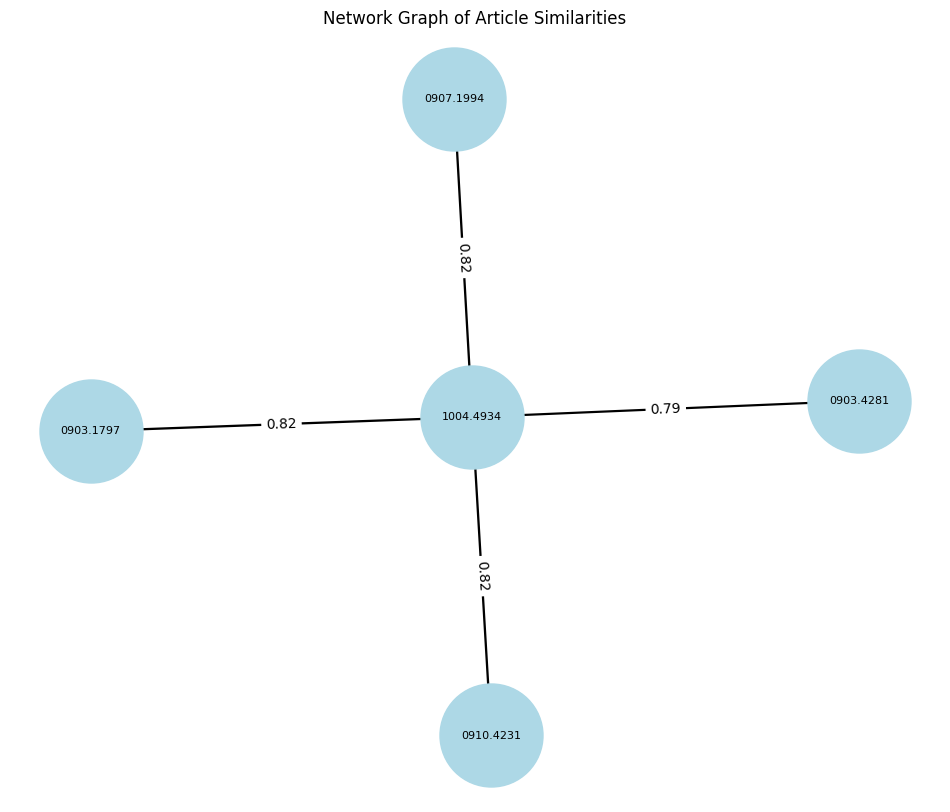

In [74]:
import networkx as nx

G = nx.Graph()

for article1, article2, similarity in similar_articles:
    G.add_edge(article1, article2, weight=similarity)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42) 
weights = nx.get_edge_attributes(G, 'weight')

nx.draw_networkx_nodes(G, pos, node_size=5500, node_color="lightblue")
nx.draw_networkx_edges(G, pos, width=[v * 2 for v in weights.values()])
nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in weights.items()})

plt.title("Network Graph of Article Similarities")
plt.axis("off")
plt.show()


---

#### Loading

In [40]:
# os.makedirs('./group_bucket', exist_ok=True)

# with open('./group_bucket/grouped_buckets.json', 'w') as f:
#     json.dump(grouped_buckets.mapValues(list).collect(), f)

# # with open('candidate_pairs.json', 'w') as f:
# #     json.dump(candidate_pairs.collect(), f)


In [41]:
# with open('./group_bucket/candidate_pairs.json', 'w') as f:
#     json.dump(candidate_pairs.collect(), f)

In [31]:
with open('./group_bucket/grouped_buckets.json', 'r') as f:
    grouped_buckets = sc.parallelize(json.load(f))  

with open('./group_bucket/candidate_pairs.json', 'r') as f:
    candidate_pairs = sc.parallelize(json.load(f)) 


---
#### Display

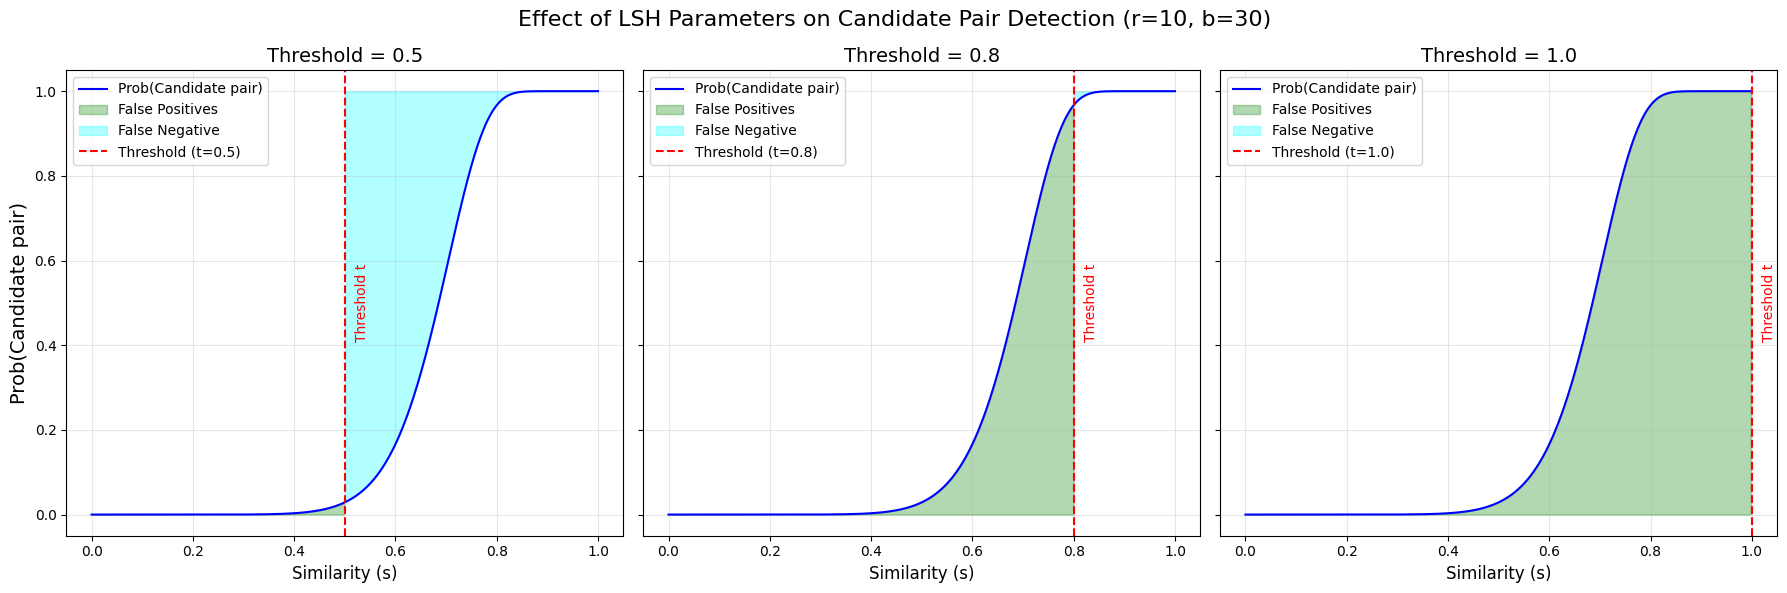

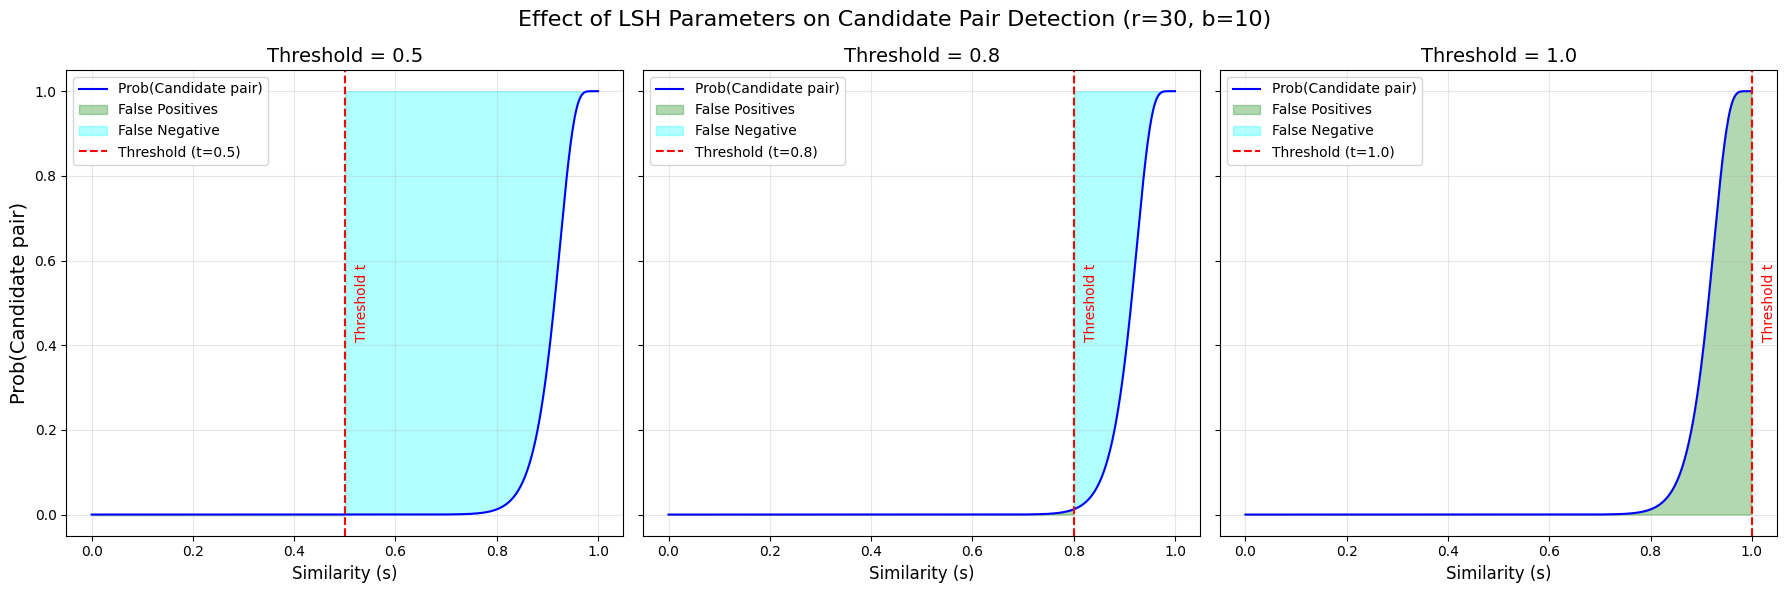

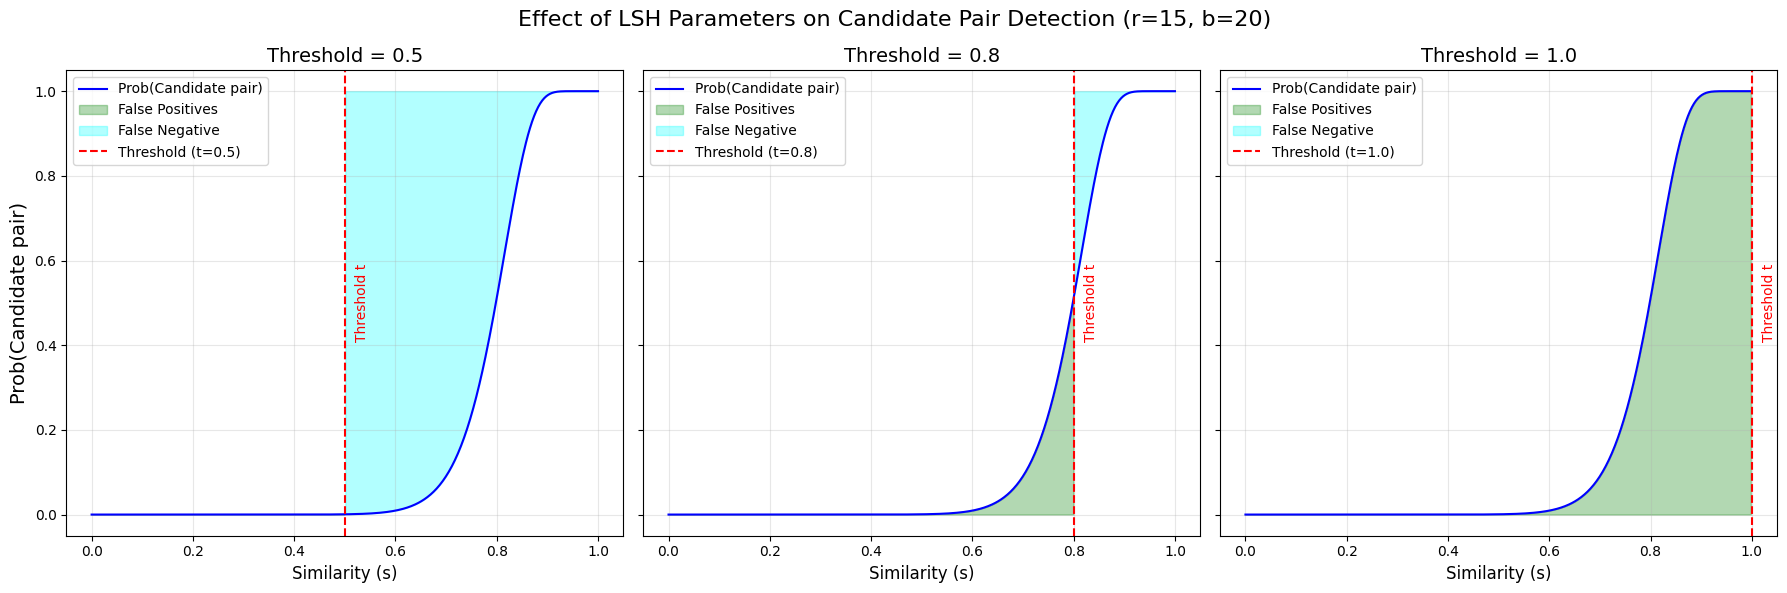

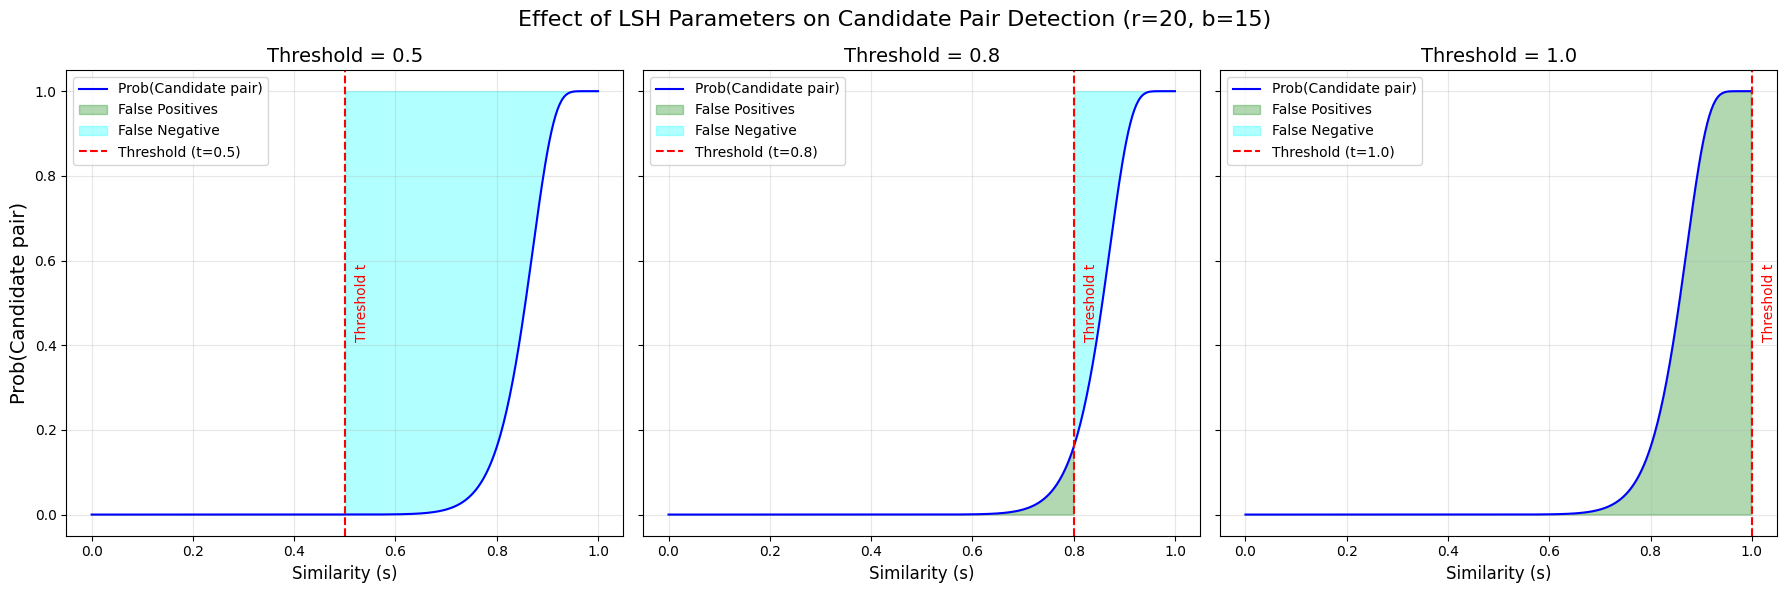

In [22]:
def plot_lsh_probability_with_above_area(r_values, b_values, thresholds):

    for r, b in zip(r_values, b_values):

        s = np.linspace(0, 1, 500)
        prob_candidate = 1 - (1 - s**r)**b

        fig, axes = plt.subplots(1, len(thresholds), figsize=(18, 6), sharey=True)
        
        for i, threshold in enumerate(thresholds):
            ax = axes[i]
            ax.plot(s, prob_candidate, label="Prob(Candidate pair)", color="blue", linewidth=1.5)

            ax.fill_between(s, prob_candidate, 0, where=(s < threshold), color="green", alpha=0.3, label="False Positives")

            ax.fill_between(s, prob_candidate, 1.0, where=(s >= threshold), color="cyan", alpha=0.3, label="False Negative")

            ax.axvline(x=threshold, color="red", linestyle="--", linewidth=1.5, label=f"Threshold (t={threshold})")
            ax.text(threshold + 0.02, 0.5, "Threshold t", color="red", fontsize=10, rotation=90, verticalalignment='center')
            
            ax.set_xlabel("Similarity (s)", fontsize=12)
            ax.set_title(f"Threshold = {threshold}", fontsize=14)
            ax.grid(alpha=0.3)
            if i == 0:
                ax.set_ylabel("Prob(Candidate pair)", fontsize=14)
            ax.legend(fontsize=10)

        fig.suptitle(f"Effect of LSH Parameters on Candidate Pair Detection (r={r}, b={b})", fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.88)  

        plt.show()

r_values = [10, 30, 15, 20]  # Rows per band
b_values = [30, 10, 20, 15]  # Number of bands
thresholds = [0.5, 0.8, 1.0]  # Similarity thresholds

plot_lsh_probability_with_above_area(r_values, b_values, thresholds)


### Second Results - Using 30% of the Dataset

In [14]:
# Randomly sample 30% of the data
subset_fraction = 0.3 
seed = 42  

sampled_rdd = cleaned_rdd.sample(False, subset_fraction, seed)

In [36]:
total_size = sampled_rdd.map(lambda x: len(str(x))).reduce(lambda x, y: x + y)
avg_size_per_record = total_size / sampled_rdd.count()
print("Average size per record:", avg_size_per_record)


Average size per record: 1482.7106173553198


In [34]:
# sampled_rdd = sampled_rdd.repartition(131)  
# print(sampled_rdd.getNumPartitions())

In [15]:
sampled_rdd.take(3)

[{'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'calculation prompt diphoton production cross sections tevatron lhc energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': 'unknown',
  'abstract': 'fully differential calculation perturbative quantum chromodynamics presented production massive photon pairs hadron colliders nexttoleading order perturbative contributions quarkantiquark gluonantiquark gluongluon subprocesses included well allorders resummation initialstate gluon radiation valid nexttonexttoleading logarithmic accuracy region phase space specified calculation reliable good agreement demonstrated data fermilab tevatron predictions made detailed tests cdf data predictions shown distributions diphoton pairs produced energy 

In [22]:
short_abstracts_rdd = sampled_rdd.filter(lambda x: len(x['abstract']) < 15)

short_abstracts = short_abstracts_rdd.map(lambda x: (x['id'], x['abstract'])).collect()

for article_id, abstract in short_abstracts:
    print(f"Article ID: {article_id}, Abstract: '{abstract}'")


Article ID: 0911.3505, Abstract: 'paper obsolete'
Article ID: 1005.0831, Abstract: 'arxiv09041778'
Article ID: 1101.5378, Abstract: 'erratum paper'
Article ID: 1110.2832, Abstract: 'probably not'
Article ID: 1210.7958, Abstract: 'book group'
Article ID: 1609.01476, Abstract: 'no'
Article ID: 2303.00551, Abstract: 'redacted arxiv'
Article ID: cond-mat/0501465, Abstract: 'paper removed'


In [17]:
short_abstracts_rdd = sampled_rdd.filter(lambda x: len(x['abstract']) < 10)

short_abstracts = short_abstracts_rdd.map(lambda x: (x['id'], x['abstract'])).collect()

for article_id, abstract in short_abstracts:
    print(f"Article ID: {article_id}, Abstract: '{abstract}'")

Article ID: 1609.01476, Abstract: 'no'


In [81]:
sampled_rdd.count()

775056

In [82]:
# sampled_rdd = sampled_rdd.filter(lambda x: x['abstract'].strip().lower() != "paper withdrawn")
# sampled_rdd.count()

775002

In [84]:
# sampled_rdd = sampled_rdd.filter(lambda x: x['abstract'].strip().lower() != "paper withdrawn author")
# sampled_rdd.count()

774967

In [45]:
# sampled_rdd = sampled_rdd.filter(lambda x: x['abstract'].strip().lower() != "unknown_abstract")
# sampled_rdd.count()

774967

#### K-Shingling ( K = 9 )

In [15]:
def extract_shingles(record, k):

    try:
        # article = json.loads(record)
        # article = record.get()
        abstract = record.get("abstract", "")
        article_id = record.get("id", None)
        
        # Generate k-shingles
        if abstract and article_id:
            shingles = {abstract[i:i+k] for i in range(len(abstract) - k + 1)}
            # Hash each shingle using MD5
            hashed_shingles = {md5(shingle.encode('utf-8')).hexdigest() for shingle in shingles}
            return [(article_id, hashed_shingles)]
            # return [(article_id, shingles)]
        else:
            return []
    except Exception as e:
        return []

# Extract shingles and hash them
k = 9  
shingled_rdd = sampled_rdd.flatMap(lambda record: extract_shingles(record, k))


In [22]:
shingled_rdd.count()

775056

In [21]:
sss = shingled_rdd.filter(lambda x: len(x[1]) < 2)

sss_new = sss.map(lambda x: (x[0], x[1])).collect()

for article_id, abstract_hashed in sss_new:
    print(f"Article ID: {article_id}, Abstract: '{abstract_hashed}'")

Article ID: 1609.01476, Abstract: 'set()'


In [17]:
# Keep only non-empty shingles
shingled_rdd = shingled_rdd.filter(lambda x: bool(x[1]))  
shingled_rdd.count()

775055

In [41]:
sss = shingled_rdd.filter(lambda x: len(x[1]) < 2)

sss_new = sss.map(lambda x: (x[0], x[1])).collect()

if sss_new == []:
    print('Nothing!')
    for article_id, abstract_hashed in sss_new:
        print(f"Article ID: {article_id}, Abstract: '{abstract_hashed}'")

Nothing!


In [17]:
shingled_rdd.take(2)

[('0704.0001',
  {'008a1e26c1b56ceab28f2ebb6c8f489f',
   '00c0b9bcdcf6c80bc28f5292404bf1cb',
   '02c45f619b70ebdc51ee3ba26170b4aa',
   '02e4868baea8d5f712702489113e2370',
   '02f515586ace075f722550c19fef3456',
   '032f264ec7b3bfdb8410e4ad1c0ed25a',
   '034b2cc785c1a6fcc4d5bf40facb96a0',
   '03dd0223cd9a1dec1b1f84090b2ef35c',
   '04a7be713129a7390b7b5f6624aa325f',
   '04aab919a951f65fceb0d458cb1c4e38',
   '056ba332fef0f107ff9bc39f3816db56',
   '05966f27cbdf5e1b93a2024ce18bfa06',
   '0691f7c36e4e5ac59c4eb07624e935ed',
   '069bc3c446ae3ed099ccea09e34e9ce2',
   '06e695e58314d04128bb319f6e72a277',
   '07dca29f4270d4c77ece44712f46eab8',
   '088c06305250b2fe72d3a05a63468566',
   '09923c4e08fd481926ef699bc7a35294',
   '09dc3ad4650c69c26cc9b2282ddcd46a',
   '0a0e286f7abac52ea6f9a39e27b46d75',
   '0c31b352404d7da00b21fc062e257267',
   '0c6062646b602ca48f427edf225617fe',
   '0d32355026dee46f64636bf160359f8a',
   '0d6f615053a32c7d014c5f1def985faf',
   '0d95d4be33e3ef139fda9be5c9bcd79c',
   '0dab1e

#### Min-Hash - Signature Matrix

In [18]:
num_hashes = 300  

# Generate Random Hash Functions
max_hash = 2**32 - 1 
hash_functions = [(random.randint(1, max_hash), random.randint(0, max_hash)) for _ in range(num_hashes)]

def minhash_signature(hashed_shingles, hash_functions):

    signature = []
    for a, b in hash_functions:
        min_hash = min((a * int(shingle, 16) + b) % max_hash for shingle in hashed_shingles)
        signature.append(min_hash)
    return signature

# Compute Min-Hash Signature for Each Article
signature_rdd = shingled_rdd.mapValues(lambda hashed_shingles: minhash_signature(hashed_shingles, hash_functions))

# Input: shingled_rdd => (article_id, hashed_shingles)
# Output: signature_rdd => (article_id, signature)
print("Sample signatures:", signature_rdd.take(2))


Sample signatures: [('0704.0001', [1579757, 6386475, 37898234, 1904901, 5025415, 14531272, 9996312, 3668595, 2447365, 291591, 7757300, 12335607, 455915, 1418154, 1096762, 5250851, 8797051, 1432341, 29196143, 1815016, 114859, 69740, 6900958, 779268, 18086473, 3325891, 3971509, 3033871, 3314415, 11468551, 12545395, 70241, 2271750, 24707354, 16851648, 5980703, 1833334, 2232509, 6602987, 9847328, 12385206, 6447772, 2002800, 4252010, 10418264, 12672468, 1335384, 3393253, 125356, 4843657, 3320401, 936960, 3648766, 11212399, 13638750, 5556673, 4067574, 731208, 18498835, 19591007, 10231484, 10244326, 26391919, 1652012, 13871993, 1000254, 12407902, 311626, 5774204, 1378286, 4031528, 2108465, 612119, 698900, 3599081, 1301014, 16526677, 6392912, 5790193, 3067601, 26582757, 5337077, 5338650, 9996309, 14674836, 18144579, 7220438, 3415827, 2767379, 392315, 2166241, 881026, 5679715, 6473515, 892972, 1849205, 2093745, 10987988, 16659974, 11691368, 2997247, 3115121, 22135693, 575545, 26341254, 4668286,

In [ ]:
signa = signature_rdd.filter(lambda x: len(x[1]) < 2)

signa_new = signa.map(lambda x: (x[0], x[1])).collect()

if signa_new == []:
    print('Nothing!')
    for article_id, abstract_hashed in signa_new:
        print(f"Article ID: {article_id}, Abstract: '{abstract_hashed}'")

In [19]:
signature_rdd.take(2)

[('0704.0001',
  [1579757,
   6386475,
   37898234,
   1904901,
   5025415,
   14531272,
   9996312,
   3668595,
   2447365,
   291591,
   7757300,
   12335607,
   455915,
   1418154,
   1096762,
   5250851,
   8797051,
   1432341,
   29196143,
   1815016,
   114859,
   69740,
   6900958,
   779268,
   18086473,
   3325891,
   3971509,
   3033871,
   3314415,
   11468551,
   12545395,
   70241,
   2271750,
   24707354,
   16851648,
   5980703,
   1833334,
   2232509,
   6602987,
   9847328,
   12385206,
   6447772,
   2002800,
   4252010,
   10418264,
   12672468,
   1335384,
   3393253,
   125356,
   4843657,
   3320401,
   936960,
   3648766,
   11212399,
   13638750,
   5556673,
   4067574,
   731208,
   18498835,
   19591007,
   10231484,
   10244326,
   26391919,
   1652012,
   13871993,
   1000254,
   12407902,
   311626,
   5774204,
   1378286,
   4031528,
   2108465,
   612119,
   698900,
   3599081,
   1301014,
   16526677,
   6392912,
   5790193,
   3067601,
   26582757,
   5

#### Effect of bands & rows per band

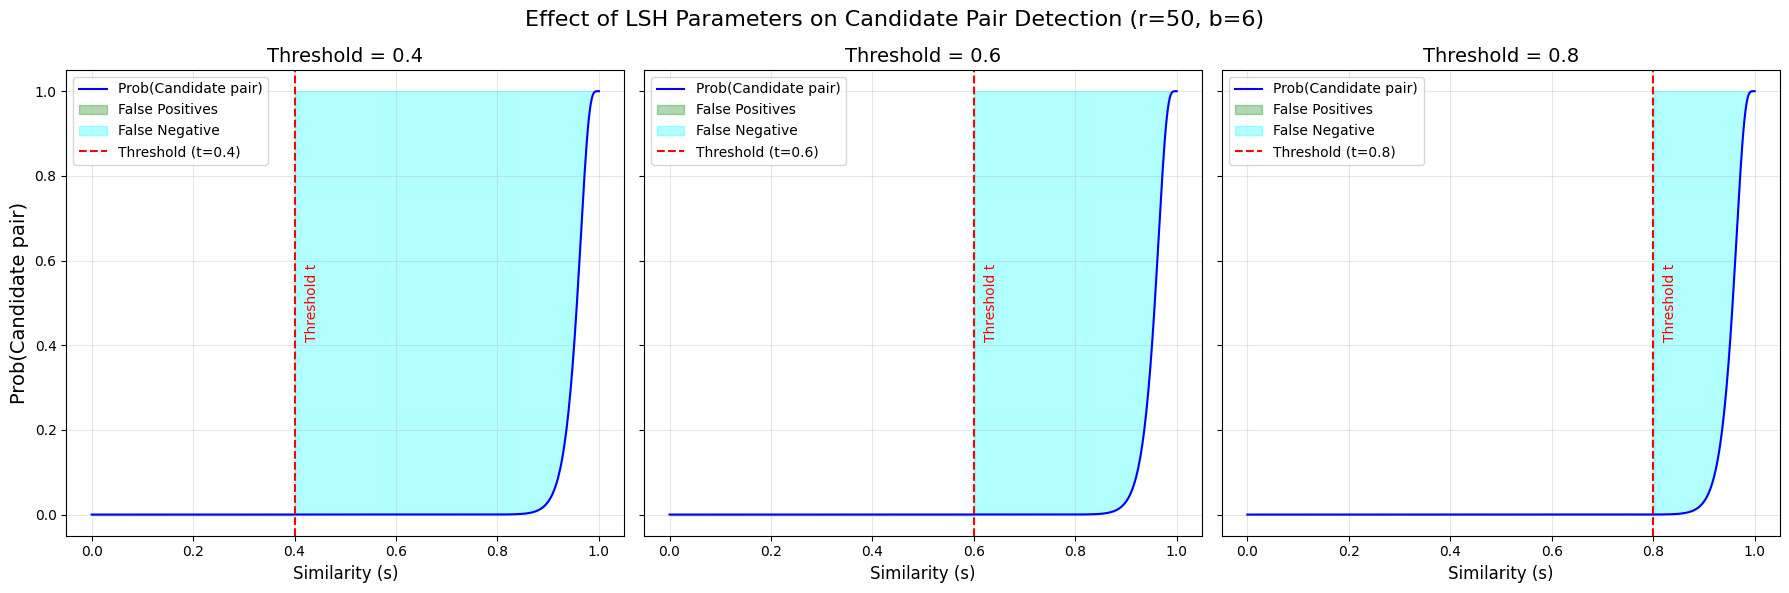

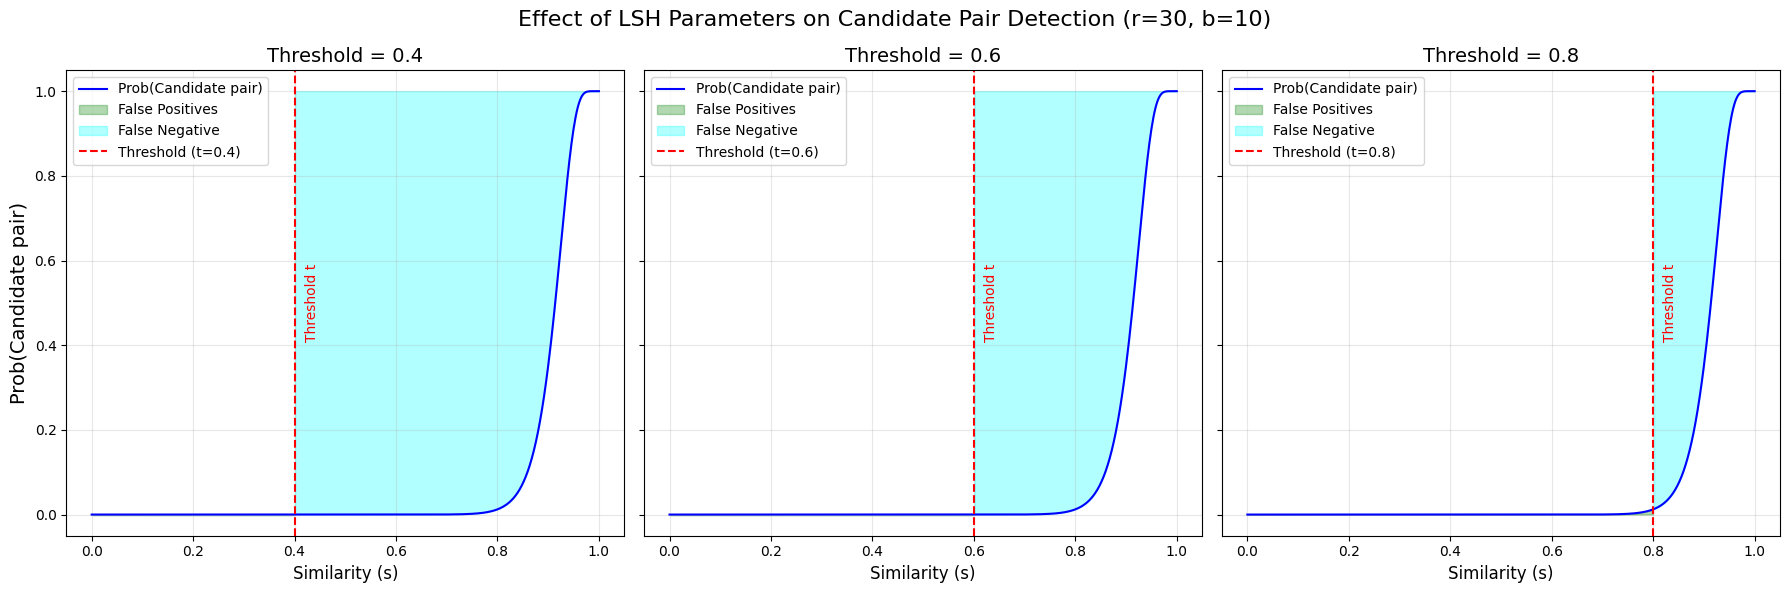

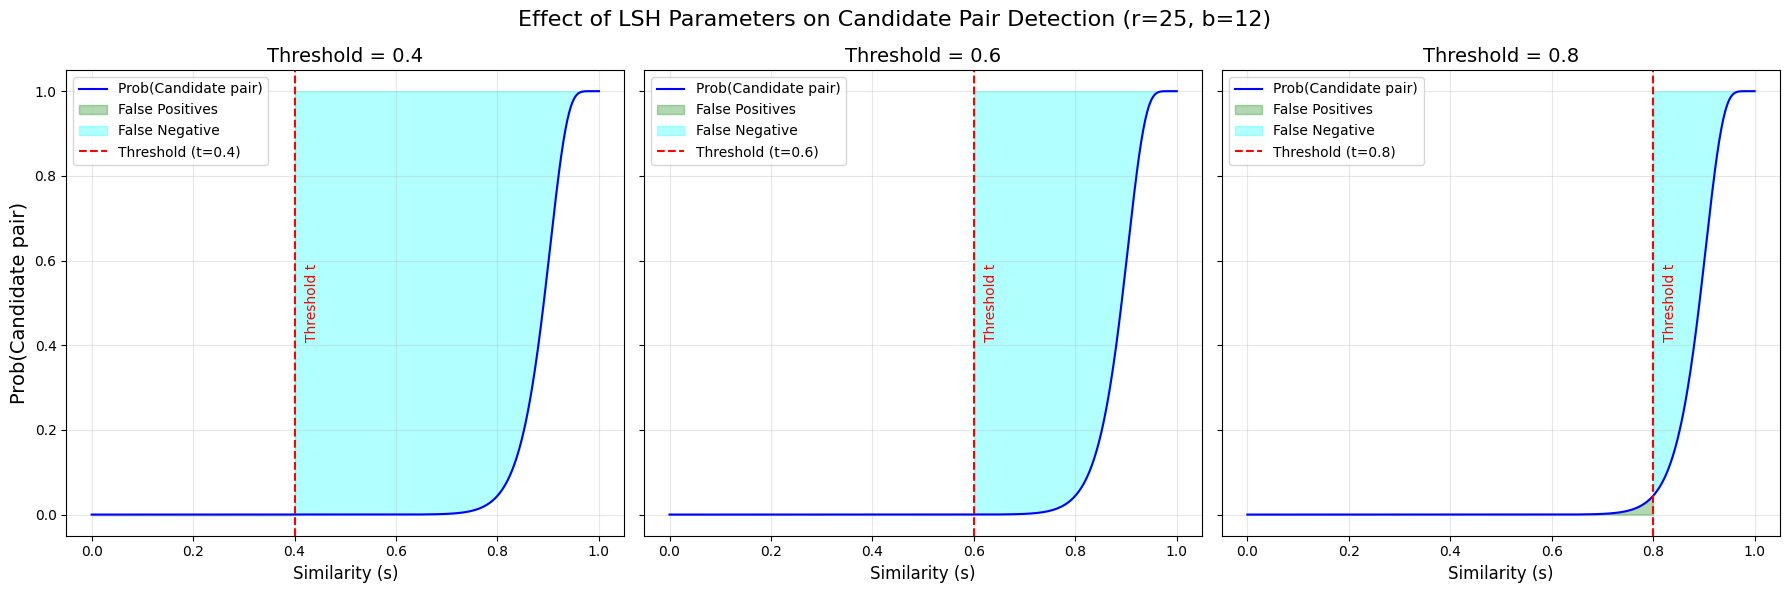

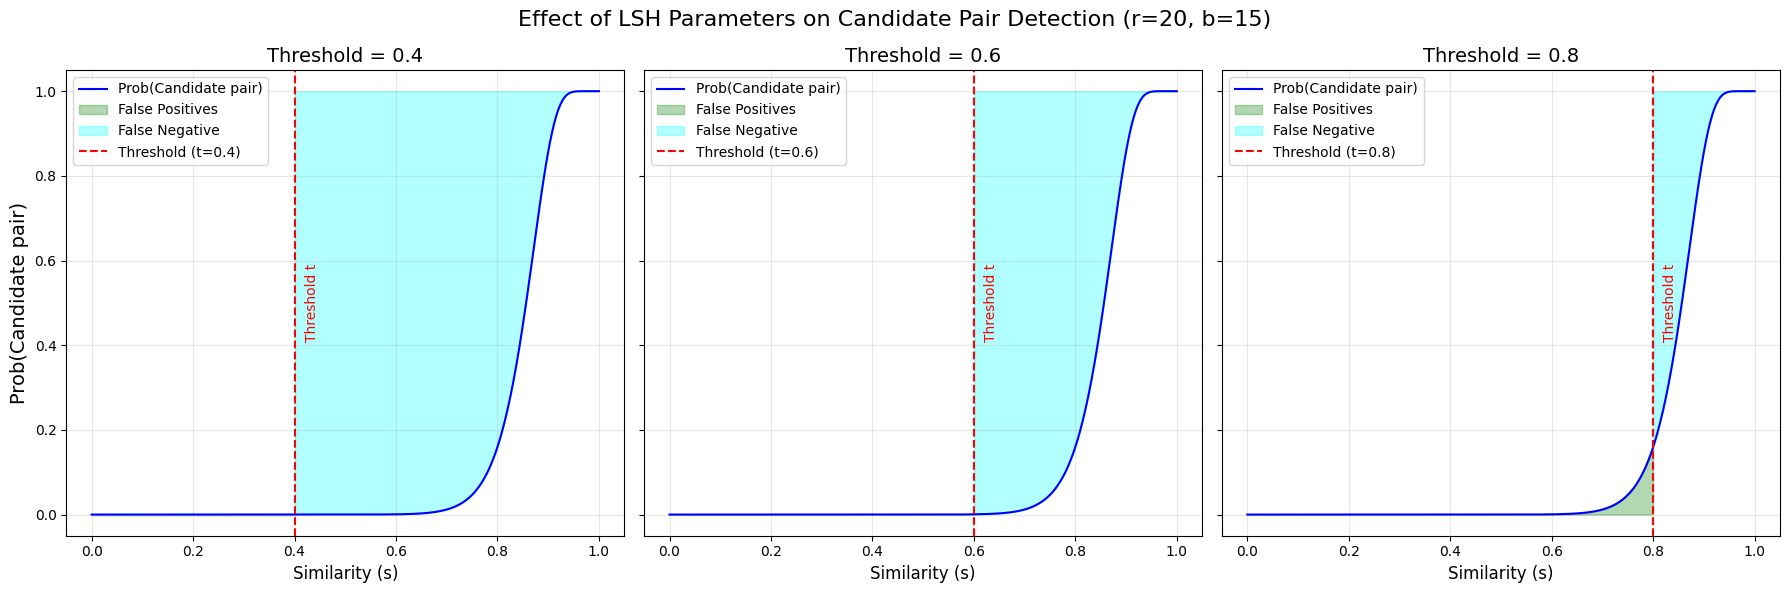

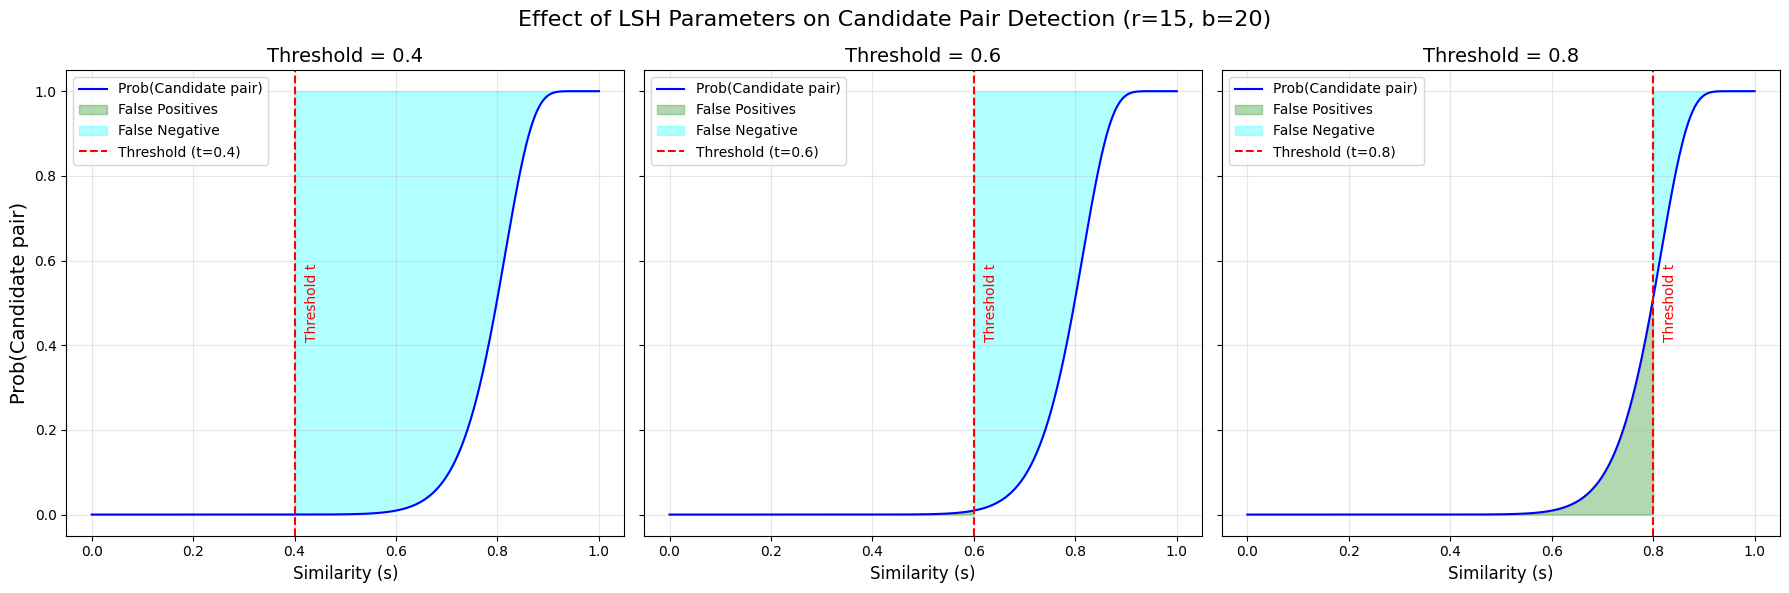

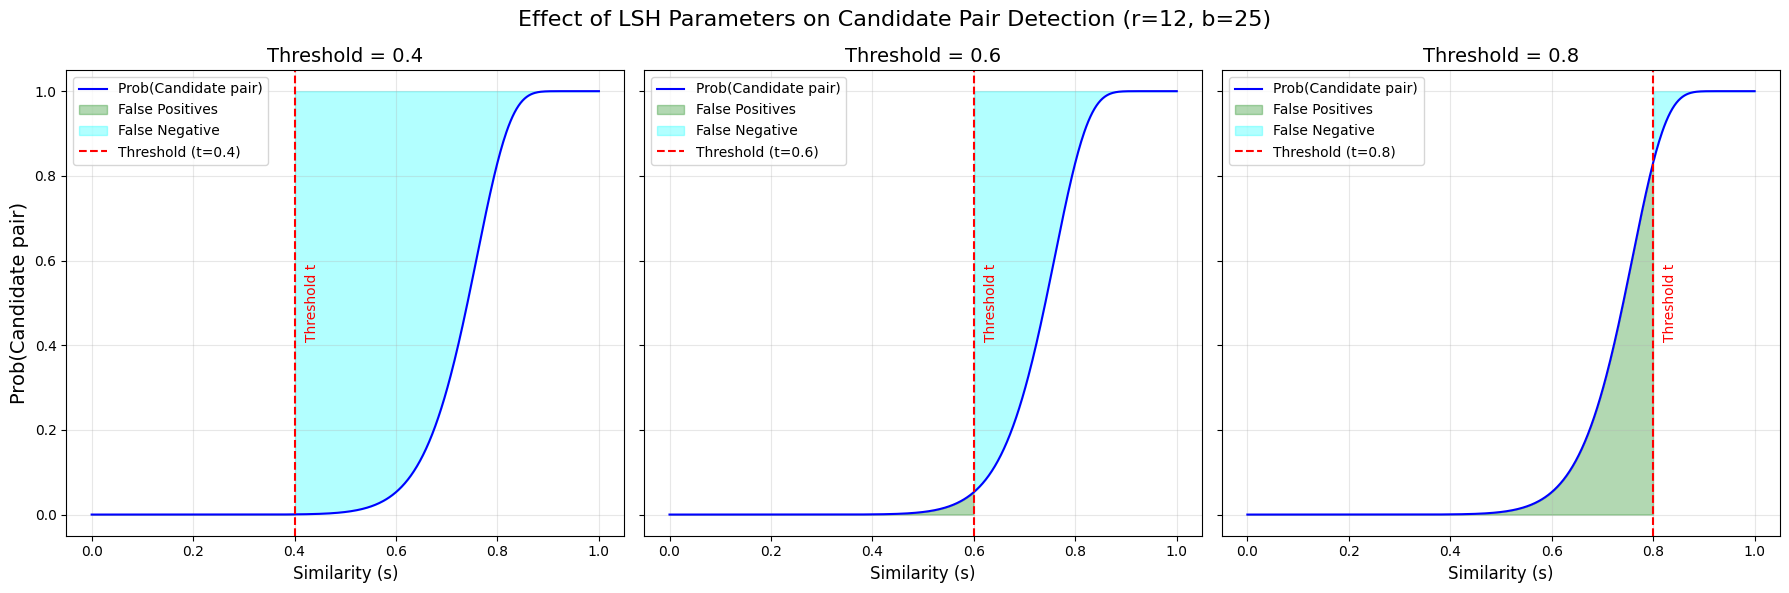

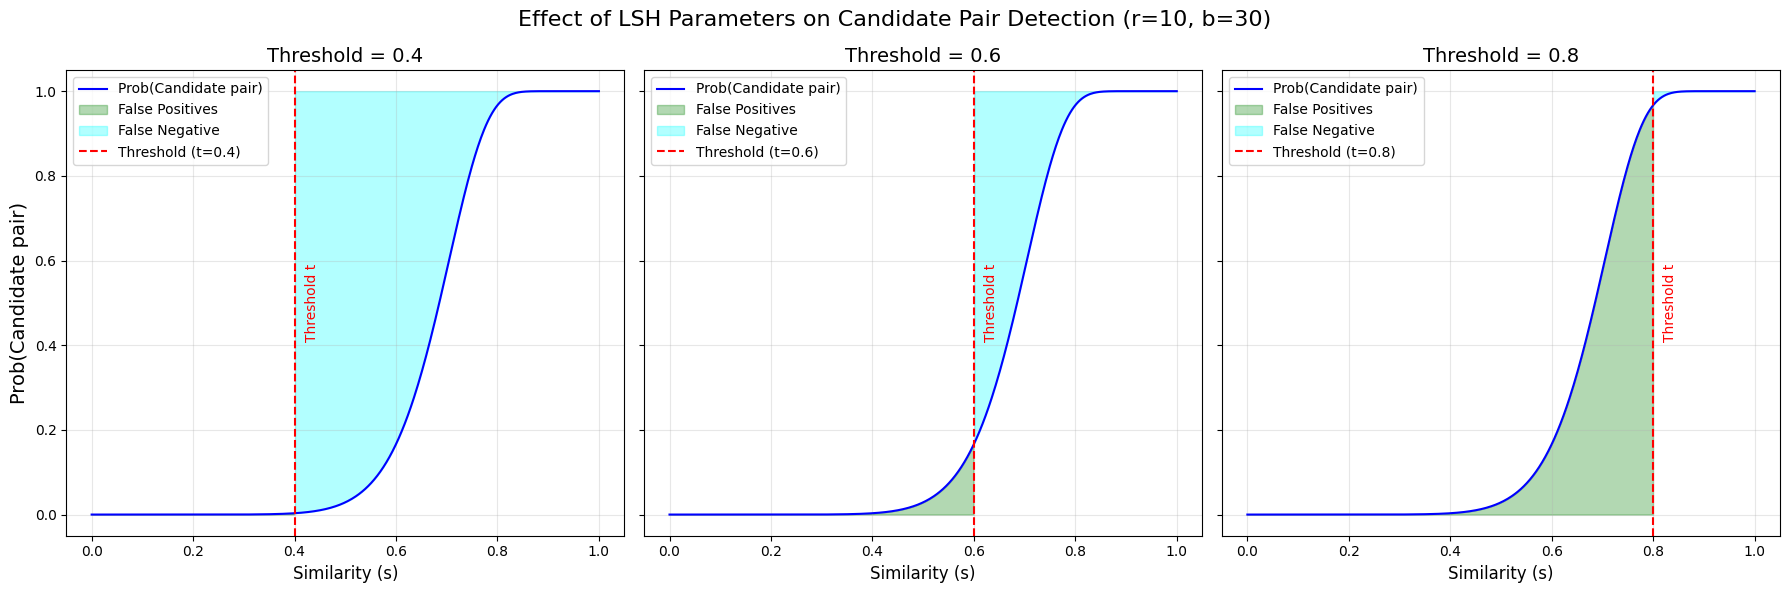

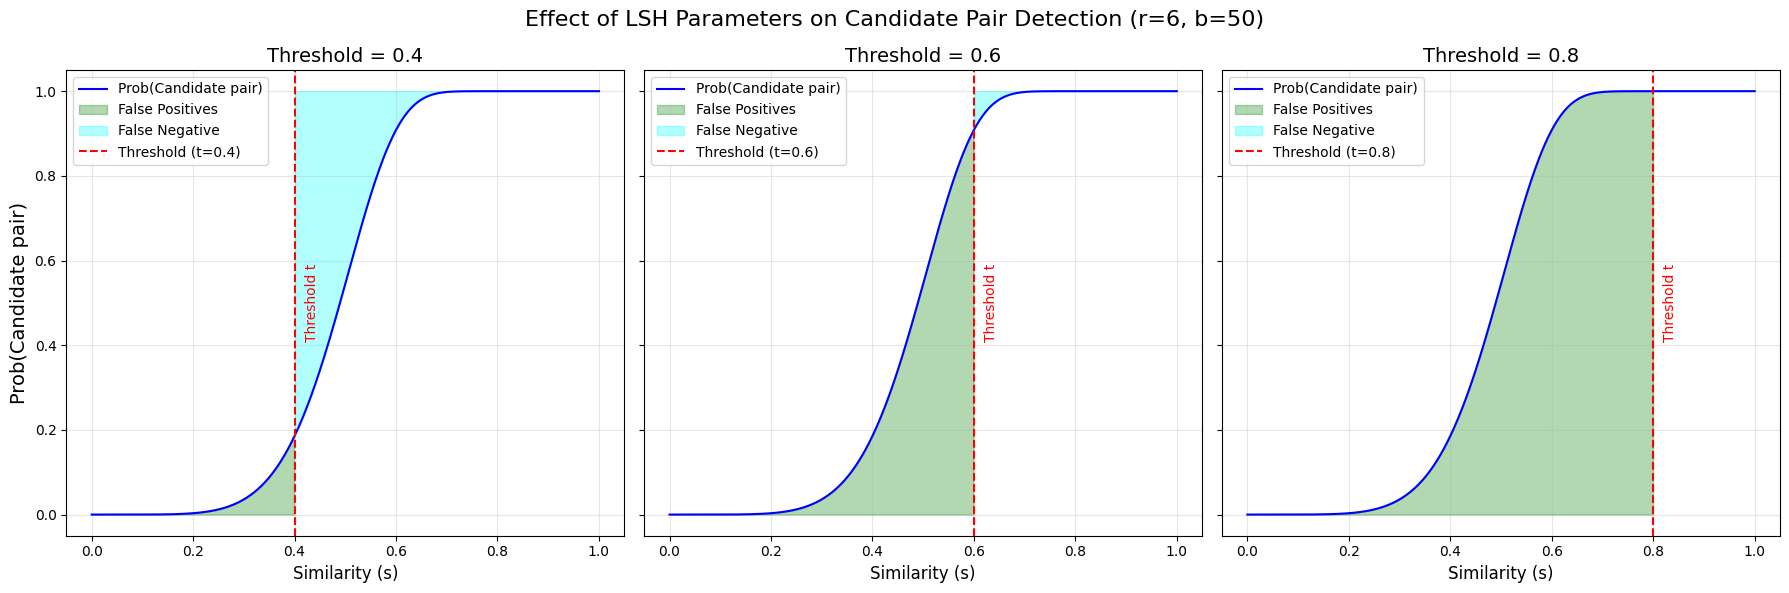

In [26]:
def plot_lsh_probability_with_above_area(r_values, b_values, thresholds):

    for r, b in zip(r_values, b_values):

        s = np.linspace(0, 1, 500)
        prob_candidate = 1 - (1 - s**r)**b

        fig, axes = plt.subplots(1, len(thresholds), figsize=(18, 6), sharey=True)
        
        for i, threshold in enumerate(thresholds):
            ax = axes[i]
            ax.plot(s, prob_candidate, label="Prob(Candidate pair)", color="blue", linewidth=1.5)

            ax.fill_between(s, prob_candidate, 0, where=(s < threshold), color="green", alpha=0.3, label="False Positives")

            ax.fill_between(s, prob_candidate, 1.0, where=(s >= threshold), color="cyan", alpha=0.3, label="False Negative")
  
            ax.axvline(x=threshold, color="red", linestyle="--", linewidth=1.5, label=f"Threshold (t={threshold})")
            ax.text(threshold + 0.02, 0.5, "Threshold t", color="red", fontsize=10, rotation=90, verticalalignment='center')
            
            ax.set_xlabel("Similarity (s)", fontsize=12)
            ax.set_title(f"Threshold = {threshold}", fontsize=14)
            ax.grid(alpha=0.3)
            if i == 0:
                ax.set_ylabel("Prob(Candidate pair)", fontsize=14)
            ax.legend(fontsize=10)

        fig.suptitle(f"Effect of LSH Parameters on Candidate Pair Detection (r={r}, b={b})", fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.88) 

        plt.show()

# Example usage
# r_values = [2, 4, 5, 10, 20]  
# b_values = [250, 125, 100, 50, 25] 

# r_values = [16, 10, 8, 5, 4, 2] 
# b_values = [25, 40, 50, 80, 100, 200]  

r_values = [50, 30, 25, 20, 15, 12, 10, 6] 
b_values = [6 , 10, 12, 15, 20, 25, 30, 50]  

thresholds = [0.4, 0.6, 0.8]  

plot_lsh_probability_with_above_area(r_values, b_values, thresholds)


#### Locality Sensitive Hashing

In [20]:
# bands = 50 
# rows_per_band = 8 

# bands = 20  
# rows_per_band = 15  

bands = 25  
rows_per_band = 12  

def lsh_buckets(article_id, signature, bands, rows_per_band):

    buckets = []
    for i in range(bands):

        start = i * rows_per_band
        end = start + rows_per_band
        band = signature[start:end]
        
        # Hash the band into a bucket
        bucket_id = hash(tuple(band)) 
        buckets.append((bucket_id, article_id))
    return buckets

# Apply LSH to generate buckets
buckets_rdd = signature_rdd.flatMap(lambda x: lsh_buckets(x[0], x[1], bands, rows_per_band))
# Input: signature_rdd => (article_id, signature)
# Output: buckets_rdd => (bucket_id, article_id)

# Group articles in the same bucket
grouped_buckets = buckets_rdd.groupByKey().mapValues(list)
# Output: grouped_buckets => (bucket_id, [article_id1, article_id2, ...])

print("Sample buckets with articles:", grouped_buckets.take(2))

# Extract Candidate Pairs
def generate_pairs(bucket):
    _, articles = bucket
    return [(articles[i], articles[j]) for i in range(len(articles)) for j in range(i + 1, len(articles))]

# Generate candidate pairs
# candidate_pairs = grouped_buckets.flatMap(generate_pairs)
candidate_pairs = grouped_buckets.flatMap(generate_pairs).map(lambda pair: tuple(sorted(pair))).distinct()
candidate_pairs = candidate_pairs.distinct()

print("Sample candidate pairs:", candidate_pairs.take(5))


Sample buckets with articles: [(-1284424355381660237, ['0704.0002']), (6706834997934123462, ['0704.0004'])]


Sample candidate pairs: [('0707.1206', 'gr-qc/0701040'), ('0708.3764', 'cond-mat/9810090'), ('0712.2753', 'hep-th/9904090'), ('0907.1677', 'hep-ex/9908037'), ('1104.2967', 'hep-th/9904090')]


#### Save & Load the Values

In [21]:
# os.makedirs('./new_group_bucket', exist_ok=True)

# with open('./new_group_bucket/grouped_buckets.json', 'w') as f:
#     json.dump(grouped_buckets.mapValues(list).collect(), f)

# with open('./new_group_bucket/candidate_pairs.json', 'w') as f:
#     json.dump(candidate_pairs.collect(), f)

In [16]:
# Load grouped_buckets
# with open('./new_group_bucket/grouped_buckets.json', 'r') as f:
#     grouped_buckets = sc.parallelize(json.load(f))  
#
# Load candidate_pairs
with open('./new_group_bucket/candidate_pairs.json', 'r') as f:
    candidate_pairs = sc.parallelize(json.load(f))  


In [19]:
candidate_pairs.take(20)

[['0707.1206', 'gr-qc/0701040'],
 ['0708.3764', 'cond-mat/9810090'],
 ['0712.2753', 'hep-th/9904090'],
 ['0907.1677', 'hep-ex/9908037'],
 ['1104.2967', 'hep-th/9904090'],
 ['1107.3172', 'hep-ph/0501249'],
 ['1112.1207', 'hep-ex/0104046'],
 ['1112.3544', 'physics/0507203'],
 ['astro-ph/0303035', 'cond-mat/9907253'],
 ['astro-ph/9904344', 'cs/0003002'],
 ['cond-mat/0105142', 'cond-mat/9904049'],
 ['cond-mat/0311225', 'cs/0003002'],
 ['cond-mat/0311225', 'physics/0502075'],
 ['cond-mat/0410032', 'quant-ph/0211147'],
 ['math/9905026', 'nucl-th/0209042'],
 ['2306.04135', '2311.00013'],
 ['hep-ex/0007049', 'hep-ex/0010080'],
 ['0712.0392', 'astro-ph/0312167'],
 ['0712.0392', 'math/0605043'],
 ['0712.0392', 'quant-ph/0611120']]

In [21]:
grouped_buckets.take(5)

[(-1378350801357243093, ['0704.0011']),
 (3433264376356966209, ['0704.0081']),
 (2069038682709312671, ['0704.0092']),
 (-7903254882529726053, ['0704.0248']),
 (1763173099045083354, ['0704.0289'])]

In [24]:
print(sampled_rdd.filter(lambda x: x['id'] == "gr-qc/0701040").collect()[0]['abstract'])
print("-------------------------------------------------------")
print(sampled_rdd.filter(lambda x: x['id'] == "0708.3764").collect()[0]['abstract'])
print("-------------------------------------------------------")
print(sampled_rdd.filter(lambda x: x['id'] == "hep-ex/0010080").collect()[0]['abstract'])
print("-------------------------------------------------------")
# print(sampled_rdd.filter(lambda x: x['id'] == "cs/0003002").collect()[0]['abstract'])
# print("-------------------------------------------------------")
print(sampled_rdd.filter(lambda x: x['id'] == "hep-ex/0007049").collect()[0]['abstract'])

paper withdrawn author
-------------------------------------------------------


paper withdrawn author
-------------------------------------------------------


using 137 fb1 data recorded cleo detector cesr investigate spectrum charmed baryons decay lambdac pi pi massive lambdac1 baryons find evidence two new states one broad invariant mass roughly 480 mev lambdac narrow invariant mass 596 1 2 mev lambdac mass results preliminary
-------------------------------------------------------


paper withdrawn authors


In [99]:
candidate_pairs_collected = candidate_pairs.collect()

candidate_ids = [id_pair[0] for id_pair in candidate_pairs_collected] + [id_pair[1] for id_pair in candidate_pairs_collected]

broadcast_ids = sc.broadcast(set(candidate_ids))

excluded_abstracts = ["paper withdrawn", "paper withdrawn author", "paper withdrawn authors"]

valid_articles = sampled_rdd.filter(
    lambda x: x['id'] in broadcast_ids.value and x['abstract'] not in excluded_abstracts
).collect()

for article in valid_articles:
    print(article['id'], article['abstract'])


0704.2398 show locations swift short hard bursts shb afterglows galactic map compare vsb batse events pointed before excess events galactic map batse vsb events none vsb swift era events fall cluster swift events needed check claim also report new study konus data vsb sample average energy 90 kev showing clear excess events 100 ms duration t90 large mean energy protons suggest vsb consist two subclasses fraction events peculiar distribution properties detectable counterparts might expected exotic sources primordial black holes show glast could add key new information study vsb bursts could help test black hole concept
0704.3292 wireless packetforwarding networks selfish nodes applications repeated game induce nodes forward others packets network performance improved however nodes boundary networks cannot benefit strategy nodes depend them problem sometimes known curse boundary nodes overcome problem approach based coalition games proposed boundary nodes use cooperative transmission hel

In [100]:
article_ids = candidate_pairs.flatMap(lambda pair: pair)

valid_articles = sampled_rdd.filter(
    lambda x: x['abstract'] not in ["paper withdrawn", "paper withdrawn author", "paper withdrawn authors"]
).map(lambda x: x['id']).collect()

filtered_articles = article_ids.filter(lambda article_id: article_id in valid_articles)

article_frequencies = filtered_articles.map(lambda x: (x, 1)).reduceByKey(lambda a, b: a + b)

top_10_articles = article_frequencies.sortBy(lambda x: x[1], ascending=False).take(10)

top_10_abstracts = sampled_rdd.filter(lambda x: x['id'] in [article for article, _ in top_10_articles]).collect()

for article, count in top_10_articles:
    abstract = next((item['abstract'] for item in top_10_abstracts if item['id'] == article), "No abstract found")
    print(f"Article ID: {article}, Count: {count}, Abstract: {abstract}")


Article ID: 0910.5433, Count: 54, Abstract: none paper withdrawn authors
Article ID: 0805.4139, Count: 19, Abstract: paper withdrawn authors see text
Article ID: math/0308029, Count: 7, Abstract: paper withdrawn author due crucial error
Article ID: 1106.5292, Count: 7, Abstract: paper withdrawn author due crucial sign error equation 5
Article ID: 1208.0048, Count: 7, Abstract: paper withdrawn author due crucial sign error equation 1
Article ID: 0907.1462, Count: 7, Abstract: paper withdrawn author due crucial sign error
Article ID: 0711.0580, Count: 7, Abstract: paper withdrawn author due crucial sign error equation 1
Article ID: cond-mat/0611374, Count: 7, Abstract: paper withdrawn author due crucial sign error equation
Article ID: 1310.4948, Count: 7, Abstract: paper withdrawn author due crucial error
Article ID: 1105.2091, Count: 7, Abstract: paper withdrawn author due crucial sign error equation 1


In [103]:
top_10_articles = article_frequencies.sortBy(lambda x: x[1], ascending=False).take(30)

top_10_abstracts = sampled_rdd.filter(lambda x: x['id'] in [article for article, _ in top_10_articles]).collect()

for article, count in top_10_articles:
    abstract = next((item['abstract'] for item in top_10_abstracts if item['id'] == article), "No abstract found")
    print(f"Article ID: {article}, Count: {count}, Abstract: {abstract}")

Article ID: 0910.5433, Count: 54, Abstract: none paper withdrawn authors
Article ID: 0805.4139, Count: 19, Abstract: paper withdrawn authors see text
Article ID: math/0308029, Count: 7, Abstract: paper withdrawn author due crucial error
Article ID: 1106.5292, Count: 7, Abstract: paper withdrawn author due crucial sign error equation 5
Article ID: 1208.0048, Count: 7, Abstract: paper withdrawn author due crucial sign error equation 1
Article ID: 0907.1462, Count: 7, Abstract: paper withdrawn author due crucial sign error
Article ID: 0711.0580, Count: 7, Abstract: paper withdrawn author due crucial sign error equation 1
Article ID: cond-mat/0611374, Count: 7, Abstract: paper withdrawn author due crucial sign error equation
Article ID: 1310.4948, Count: 7, Abstract: paper withdrawn author due crucial error
Article ID: 1105.2091, Count: 7, Abstract: paper withdrawn author due crucial sign error equation 1
Article ID: 1105.2090, Count: 7, Abstract: paper withdrawn author due crucial sign er

#### Check Similarity

##### First Article

In [36]:
check = '0704.0111'

is_available = candidate_pairs.filter(lambda pair: check in pair).isEmpty() == False

print(f"'{check}' is {'available' if is_available else 'not available'}")


'0704.0111' is not available


In [35]:
check = 'hep-ex/0010080'

is_available = candidate_pairs.filter(lambda pair: check in pair).isEmpty() == False

print(f"'{check}' is {'available' if is_available else 'not available'}")


'hep-ex/0010080' is available


In [26]:
keyed_shingled_rdd = shingled_rdd.map(lambda x: (x[0], x[1])) 

def compute_similarity(pair_shingles):

    ((id1, id2), (shingles1, shingles2)) = pair_shingles

    shingles1 = set(shingles1)
    shingles2 = set(shingles2)

    intersection = len(shingles1 & shingles2)
    union = len(shingles1 | shingles2)
    similarity = intersection / union if union != 0 else 0.0
    return (id1, id2, similarity)

def filter_candidates(candidate, input_id):
    return candidate[0] == input_id or candidate[1] == input_id

def find_similar_articles(input_article_id, threshold=0.8):

    filtered_candidates = candidate_pairs.filter(
        lambda pair: filter_candidates(pair, input_article_id)
    )

    joined_candidates = (
        filtered_candidates
        .map(lambda pair: (pair[0], pair)) 
        .join(keyed_shingled_rdd) 
        .map(lambda x: (x[1][0][1], (x[1][0][0], x[1][1])))  
        .join(keyed_shingled_rdd) 
        .map(lambda x: ((x[1][0][0], x[0]), (set(x[1][0][1]), set(x[1][1])))) 
    )

    similar_articles = (
        joined_candidates
        .map(lambda pair: compute_similarity(pair))  
        .filter(lambda x: x[2] >= threshold)
    )

    return similar_articles.collect()

input_article_id = "hep-ex/0010080"  
threshold = 0.5
similar_articles = find_similar_articles(input_article_id, threshold=threshold)

print(f"Articles similar to {input_article_id}:", similar_articles)

Articles similar to hep-ex/0010080: [('hep-ex/0007049', 'hep-ex/0010080', 1.0)]


In [23]:
print(sampled_rdd.filter(lambda x: x['id'] == "hep-ex/0010080").collect()[0]['abstract'])
print("-------------------------------------------------------")
print(sampled_rdd.filter(lambda x: x['id'] == "hep-ex/0007049").collect()[0]['abstract'])

using 137 fb1 data recorded cleo detector cesr investigate spectrum charmed baryons decay lambdac pi pi massive lambdac1 baryons find evidence two new states one broad invariant mass roughly 480 mev lambdac narrow invariant mass 596 1 2 mev lambdac mass results preliminary
-------------------------------------------------------


using 137 fb1 data recorded cleo detector cesr investigate spectrum charmed baryons decay lambdac pi pi massive lambdac1 baryons find evidence two new states one broad invariant mass roughly 480 mev lambdac narrow invariant mass 596 1 2 mev lambdac mass results preliminary


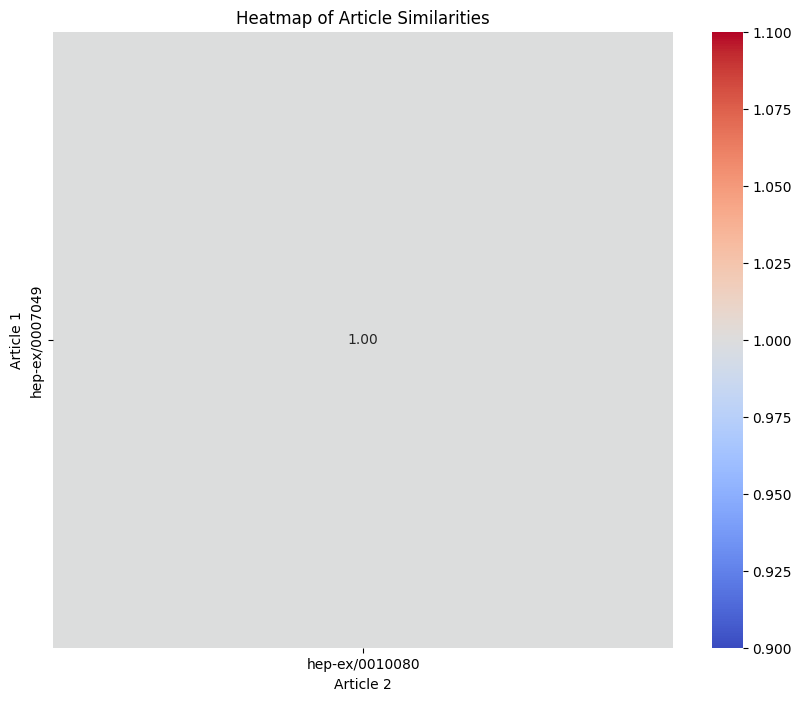

In [27]:
df_similar = pd.DataFrame(similar_articles, columns=["Article 1", "Article 2", "Similarity"])

heatmap_data = df_similar.pivot(index="Article 1", columns="Article 2", values="Similarity")

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap of Article Similarities")
plt.show()


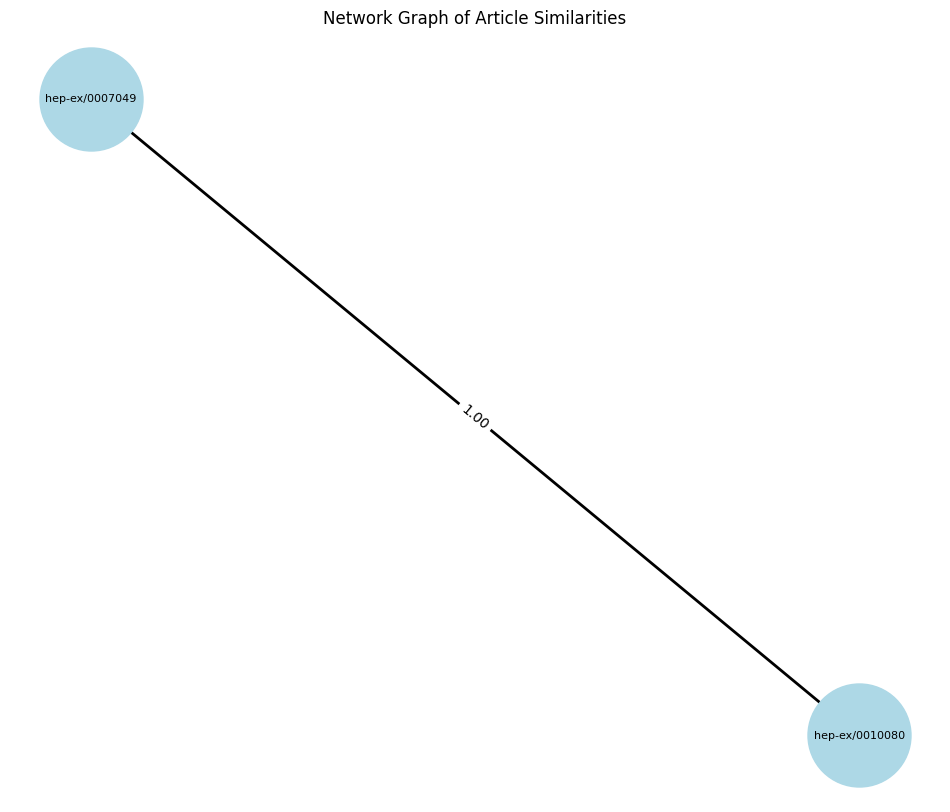

In [28]:
G = nx.Graph()

for article1, article2, similarity in similar_articles:
    G.add_edge(article1, article2, weight=similarity)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)  
weights = nx.get_edge_attributes(G, 'weight')

nx.draw_networkx_nodes(G, pos, node_size=5500, node_color="lightblue")
nx.draw_networkx_edges(G, pos, width=[v * 2 for v in weights.values()])
nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in weights.items()})

plt.title("Network Graph of Article Similarities")
plt.axis("off")
plt.show()


##### Second Article

In [34]:
check = '1004.4934'

is_available = candidate_pairs.filter(lambda pair: check in pair).isEmpty() == False

print(f"'{check}' is {'available' if is_available else 'not available'}")


'1004.4934' is available


In [20]:
input_article_id = "1004.4934"  
threshold = 0.5 
similar_articles = find_similar_articles(input_article_id, threshold=threshold)

print(f"Articles similar to {input_article_id}:", similar_articles)

Articles similar to 1004.4934: [('0907.1994', '1004.4934', 0.8202247191011236), ('1003.5127', '1004.4934', 0.807909604519774), ('0902.4361', '1004.4934', 0.7944444444444444), ('0910.4231', '1004.4934', 0.8202247191011236), ('0903.1797', '1004.4934', 0.8171428571428572), ('0903.4281', '1004.4934', 0.7900552486187845)]


In [112]:
len(similar_articles)

6

In [24]:
print(sampled_rdd.filter(lambda x: x['id'] == "1004.4934").collect()[0]['abstract'])
print("-------------------------------------------------------")
print(sampled_rdd.filter(lambda x: x['id'] == "0907.1994").collect()[0]['abstract'])
print("-------------------------------------------------------")
print(sampled_rdd.filter(lambda x: x['id'] == "1003.5127").collect()[0]['abstract'])
print("-------------------------------------------------------")
print(sampled_rdd.filter(lambda x: x['id'] == "0902.4361").collect()[0]['abstract'])
print("-------------------------------------------------------")
print(sampled_rdd.filter(lambda x: x['id'] == "0910.4231").collect()[0]['abstract'])
print("-------------------------------------------------------")
print(sampled_rdd.filter(lambda x: x['id'] == "0903.1797").collect()[0]['abstract'])
print("-------------------------------------------------------")
print(sampled_rdd.filter(lambda x: x['id'] == "0903.4281").collect()[0]['abstract'])

twenty four calcium isotopes far observed discovery isotopes discussed isotope brief summary first refereed publication including production identification method presented
-------------------------------------------------------


twentyfour vanadium isotopes far observed discovery isotopes discussed isotope brief summary first refereed publication including production identification method presented
-------------------------------------------------------


thirtyeight tin isotopes far observed discovery isotopes discussed isotope brief summary first refereed publication including production identification method presented
-------------------------------------------------------


twentynine arsenic isotopes far observed discovery isotopes discussed isotope brief summary first refereed publication including production identification method presented
-------------------------------------------------------


thirtyseven cadmium isotopes far observed discovery isotopes discussed isotope brief summary first refereed publication including production identification method presented
-------------------------------------------------------


thirtysix gold isotopes far observed discovery isotopes discussed isotope brief summary first refereed publication including production identification method presented
-------------------------------------------------------


thirtyfive tungsten isotopes far observed discovery isotopes discussed isotope brief summary first refereed publication including production identification method presented


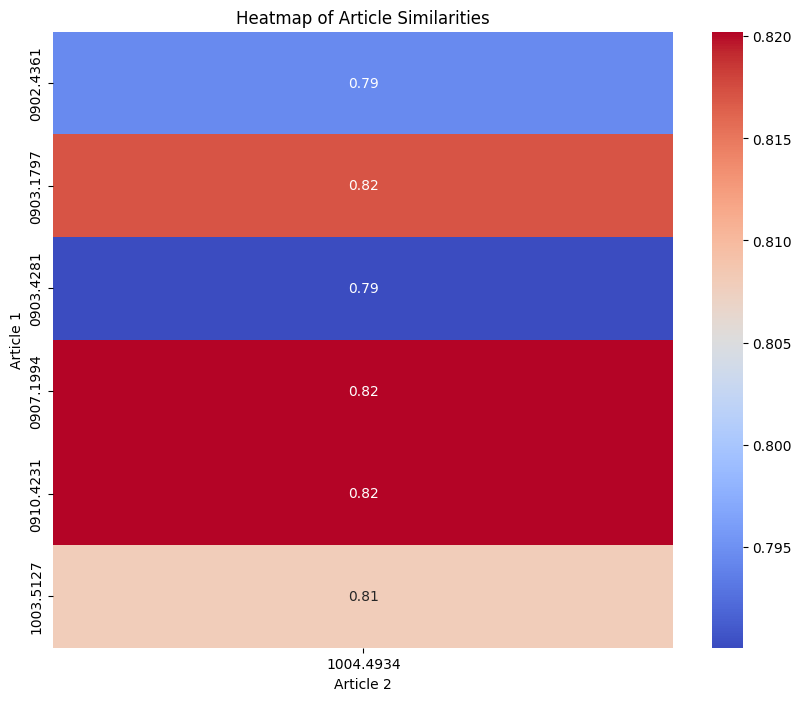

In [21]:
df_similar = pd.DataFrame(similar_articles, columns=["Article 1", "Article 2", "Similarity"])

heatmap_data = df_similar.pivot(index="Article 1", columns="Article 2", values="Similarity")

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap of Article Similarities")
plt.show()


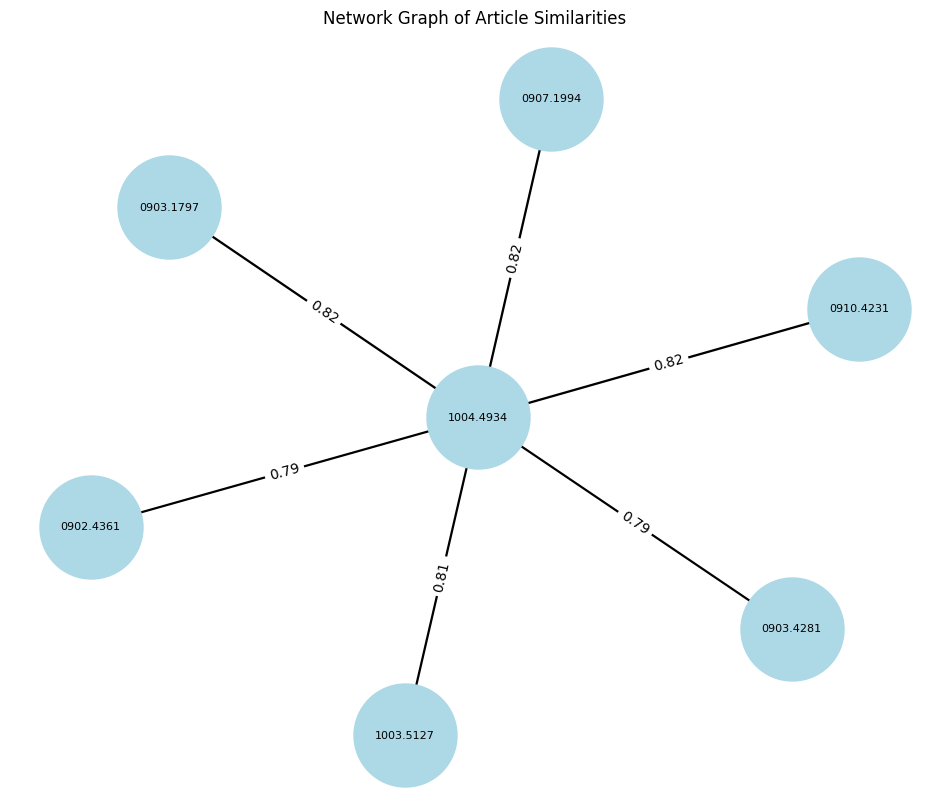

In [22]:
G = nx.Graph()

for article1, article2, similarity in similar_articles:
    G.add_edge(article1, article2, weight=similarity)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42) 
weights = nx.get_edge_attributes(G, 'weight')

nx.draw_networkx_nodes(G, pos, node_size=5500, node_color="lightblue")
nx.draw_networkx_edges(G, pos, width=[v * 2 for v in weights.values()])
nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in weights.items()})

plt.title("Network Graph of Article Similarities")
plt.axis("off")
plt.show()


In [81]:
labels = list(set([article1 for article1, _, _ in similar_articles] + [article2 for _, article2, _ in similar_articles]))
source = [labels.index(a1) for a1, a2, _ in similar_articles]
target = [labels.index(a2) for a1, a2, _ in similar_articles]
value = [sim * 100 for _, _, sim in similar_articles]  

fig = go.Figure(data=[go.Sankey(
    node=dict(
        label=labels
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    )
)])

fig.update_layout(
    title_text="Chord Diagram of Article Similarities (in %)",
    font_size=10
)

fig.show()


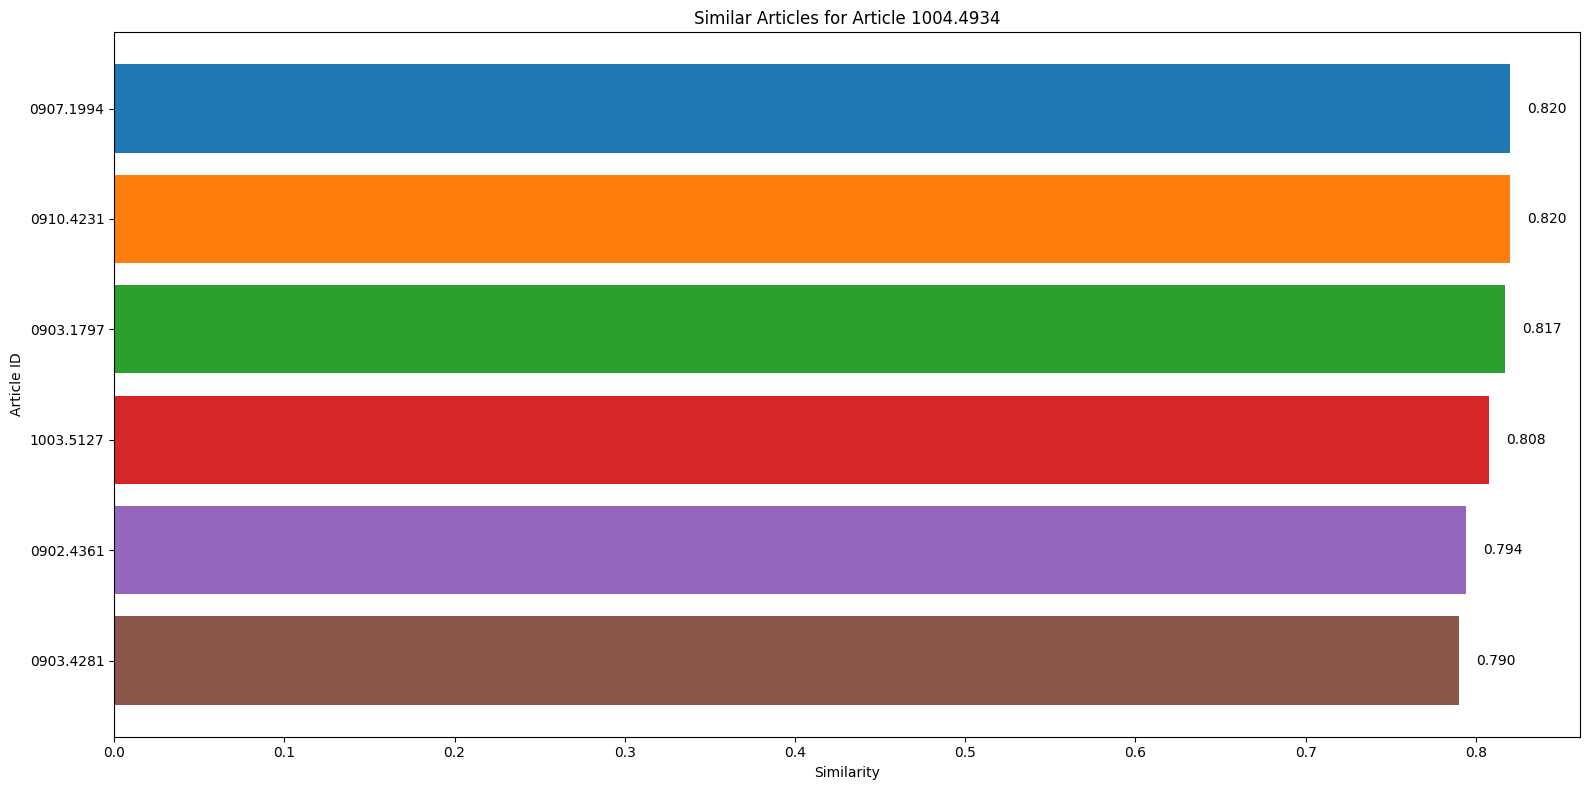

In [61]:
top_similar = sorted(similar_articles, key=lambda x: x[2], reverse=True)[:10]
articles, scores = zip(*[(f"{a1}", sim) for a1, a2, sim in top_similar])

unique_colors = list(mcolors.TABLEAU_COLORS.values())[:len(scores)]

plt.figure(figsize=(16, 8))
bars = plt.barh(articles, scores, color=unique_colors)

for bar, score in zip(bars, scores):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2, 
             f"{score:.3f}", va='center', fontsize=10)

plt.xlabel("Similarity")
plt.ylabel("Article ID")
plt.title(f"Similar Articles for Article {input_article_id}")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


##### Third Article

In [104]:
check = '0805.4139'

is_available = candidate_pairs.filter(lambda pair: check in pair).isEmpty() == False

print(f"'{check}' is {'available' if is_available else 'not available'}")


'0805.4139' is available


In [105]:
input_article_id = "0805.4139" 
threshold = 0.3  
similar_articles = find_similar_articles(input_article_id, threshold=threshold)

print(f"Articles similar to {input_article_id}:", similar_articles)

Articles similar to 0805.4139: [('0805.4139', 'hep-ex/0104046', 0.625), ('0805.4139', 'cond-mat/0410032', 0.625), ('0805.4139', '1107.3172', 0.625), ('0805.4139', 'quant-ph/0211147', 0.625), ('0805.4139', 'cond-mat/0002217', 0.625), ('0708.0110', '0805.4139', 0.625), ('0805.4139', '1112.3544', 0.625), ('0805.4139', 'cond-mat/9907253', 0.625), ('0805.4139', 'cond-mat/9806011', 0.625), ('0805.4139', 'quant-ph/0608002', 0.625), ('0805.4139', 'hep-ex/9908037', 0.625), ('0805.4139', 'math/0702880', 0.625), ('0805.4139', 'cond-mat/9908267', 0.625), ('0805.4139', 'cond-mat/0311225', 0.625), ('0805.4139', 'cond-mat/0104259', 0.625), ('0805.4139', 'cs/0003002', 0.625), ('0805.4139', 'cond-mat/0303093', 0.625), ('0805.4139', 'cond-mat/0507258', 0.625), ('0805.4139', 'math/9905026', 0.625)]


In [110]:
len(similar_articles)

19

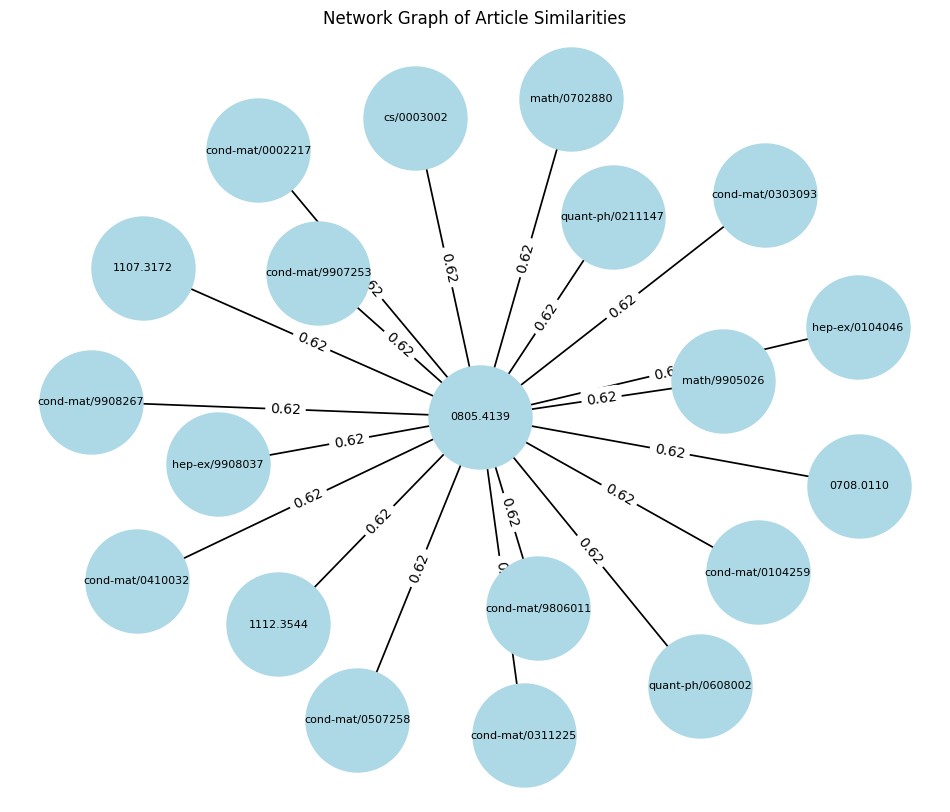

In [109]:
G = nx.Graph()

for article1, article2, similarity in similar_articles:
    G.add_edge(article1, article2, weight=similarity)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)  
weights = nx.get_edge_attributes(G, 'weight')

nx.draw_networkx_nodes(G, pos, node_size=5500, node_color="lightblue")
nx.draw_networkx_edges(G, pos, width=[v * 2 for v in weights.values()])
nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in weights.items()})

plt.title("Network Graph of Article Similarities")
plt.axis("off")
plt.show()


##### Fourth Article

In [17]:
check = '1810.05218'

is_available = candidate_pairs.filter(lambda pair: check in pair).isEmpty() == False

print(f"'{check}' is {'available' if is_available else 'not available'}")


'1810.05218' is available


In [18]:
input_article_id = "1810.05218" 
threshold = 0.3  
similar_articles = find_similar_articles(input_article_id, threshold=threshold)

print(f"Articles similar to {input_article_id}:", similar_articles)

Articles similar to 1810.05218: [('1810.05218', '1912.12662', 0.5578231292517006)]


In [22]:
print(keyed_shingled_rdd.filter(lambda x: x[0] == "1810.05218").collect())
print("-------------------------------------------------------")
print(keyed_shingled_rdd.filter(lambda x: x[0] == "1912.12662").collect())

[('1810.05218', {'806de7affc0a662592f19d40074d2c72', 'cf6dbaea0dc5a5825859d289904554d9', '32ef50d7966148cdeb1405dc6b77d17e', '8e22c606ced457661583b8d96fc477a9', 'fc68ec1e9f6a1540903901c9c2b087d2', 'f7295d61d6b8fb3e22572ce4b0948ff1', 'f30c1b5bef90d2586a3a55c723976877', 'dfdf42ecdd816f28fdd40748fb0baaea', 'ac15329c3eff06f4d33e53afd4c16cc4', 'e12858bc9725d9e28427800c7ba12414', '80dd3b918370f6d2ea8a7922cc197dfd', '1dd2f9838dd5c3e78e636af94d566feb', '2820421efe44c545c113242cb214f1d6', '02d5363172da3e578a0fe68ff1c3eff1', 'ec2f25776e75c19154d67b045a2015ad', '80da5d53a7d50df7fba08a3847e36352', '09ebf1ef3a7953f13e1f3dee991bdc3b', 'acbf7855a4b658e51dd6dbb2d64029c6', '8c8284b49c00b480084accd4898e06f0', '839b4e9555cebb248a12ec0447599979', '63e2ecf185f31ba34ebee14eaba38ea8', '41050e52f807fcabec86cc4a7330f12b', '90069fb464db0eb8033643ca8786dc7e', '3df65470b4aa228994f8113dfb17b101', '1ea84bb291ccde9c82aac2ceb1c50d55', '15f7611d7c6c394effc6540895e57cee', '5803b0bf240be2084957c4fd45674590', 'a1bafb797c

[('1912.12662', {'5cc718e87b58639a9edeb19916fd164e', '806de7affc0a662592f19d40074d2c72', 'cf6dbaea0dc5a5825859d289904554d9', '32ef50d7966148cdeb1405dc6b77d17e', '8e22c606ced457661583b8d96fc477a9', 'f7295d61d6b8fb3e22572ce4b0948ff1', 'e846f71ec5decc8e778c23ab88ae4c36', 'f30c1b5bef90d2586a3a55c723976877', 'dfdf42ecdd816f28fdd40748fb0baaea', 'ac15329c3eff06f4d33e53afd4c16cc4', 'e12858bc9725d9e28427800c7ba12414', '80dd3b918370f6d2ea8a7922cc197dfd', '1dd2f9838dd5c3e78e636af94d566feb', '2820421efe44c545c113242cb214f1d6', 'ec2f25776e75c19154d67b045a2015ad', 'c6bb343d86decfb0776aa77f084c26f9', '80da5d53a7d50df7fba08a3847e36352', '09ebf1ef3a7953f13e1f3dee991bdc3b', 'bb124ba18db6db113bf3ef0319040101', '839b4e9555cebb248a12ec0447599979', '1e8894c685f89491c355b9624fd8b590', '63e2ecf185f31ba34ebee14eaba38ea8', '41050e52f807fcabec86cc4a7330f12b', '90069fb464db0eb8033643ca8786dc7e', '3df65470b4aa228994f8113dfb17b101', '1ea84bb291ccde9c82aac2ceb1c50d55', 'b472e14b96c29343046b0bf58597b4ff', 'be99e1b56a

In [19]:
print(sampled_rdd.filter(lambda x: x['id'] == "1810.05218").collect()[0]['abstract'])
print("-------------------------------------------------------")
print(sampled_rdd.filter(lambda x: x['id'] == "1912.12662").collect()[0]['abstract'])

analyse special classes biorthogonal sets vectors hilbert krein spaces relations mathcalg quasi bases also discuss relevance concrete quantum mechanical system driven manifestly non selfadjoint hamiltonians
-------------------------------------------------------


analyze special classes biorthogonal sets vectors hilbert krein spaces relations generalized riesz systems way notion firstsecond type sequences introduced studied also discuss relevance concrete quantum mechanical system driven manifestly non selfadjoint hamiltonians


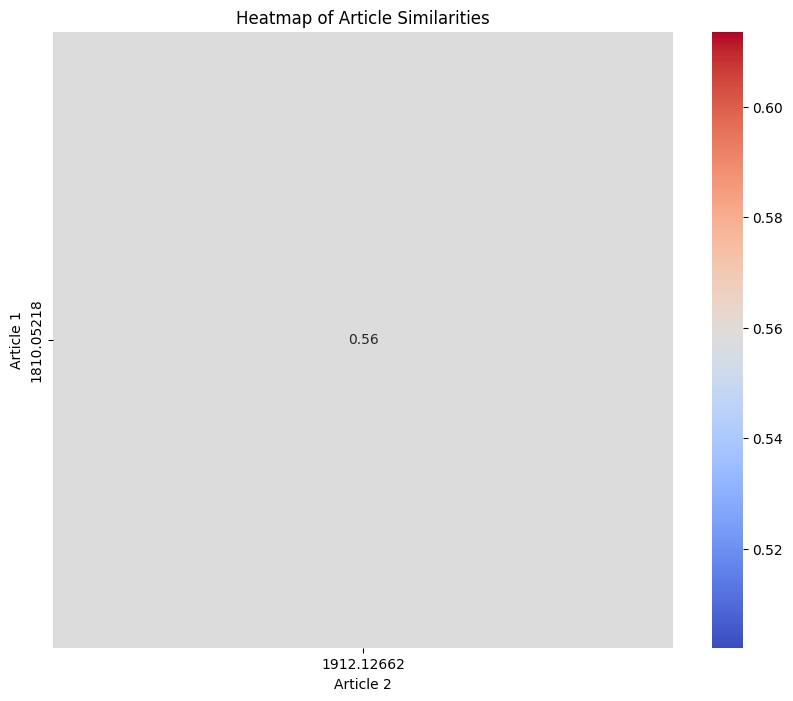

In [20]:
df_similar = pd.DataFrame(similar_articles, columns=["Article 1", "Article 2", "Similarity"])

heatmap_data = df_similar.pivot(index="Article 1", columns="Article 2", values="Similarity")

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap of Article Similarities")
plt.show()


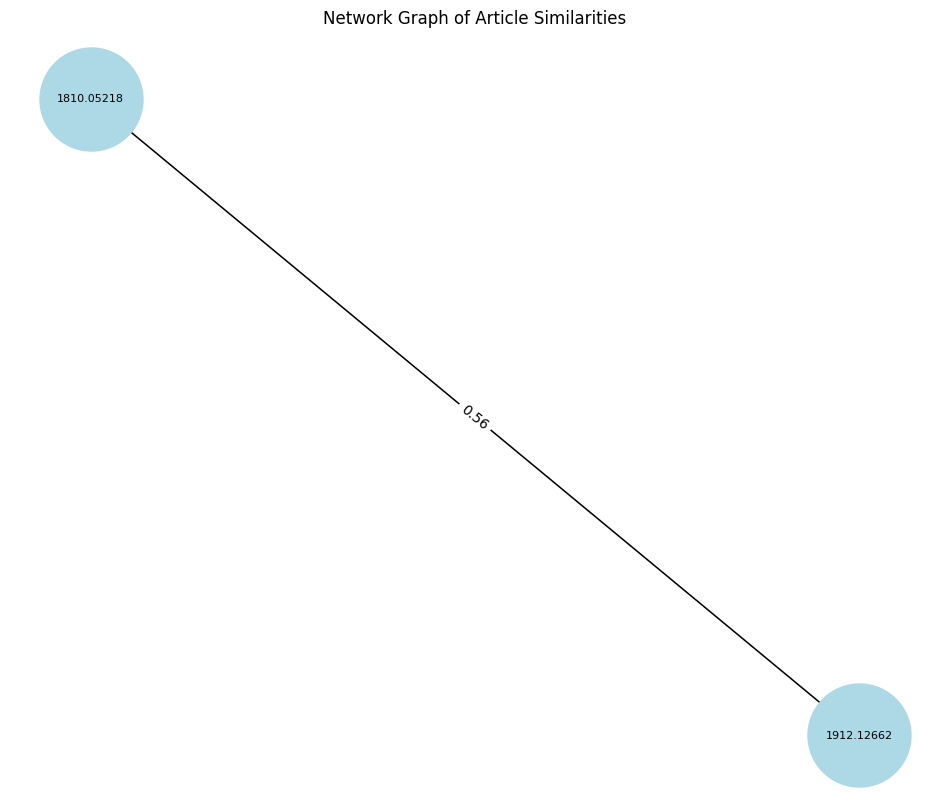

In [21]:
G = nx.Graph()

for article1, article2, similarity in similar_articles:
    G.add_edge(article1, article2, weight=similarity)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42) 
weights = nx.get_edge_attributes(G, 'weight')

nx.draw_networkx_nodes(G, pos, node_size=5500, node_color="lightblue")
nx.draw_networkx_edges(G, pos, width=[v * 2 for v in weights.values()])
nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in weights.items()})

plt.title("Network Graph of Article Similarities")
plt.axis("off")
plt.show()
